# Homework 2 - Unsupervised Deep Learning

In [1]:
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import itertools
import random 
import os 

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn

# Download Dataset

In [2]:
### Download the data and create dataset
data_dir = 'dataset'
train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw




Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw




Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw




Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


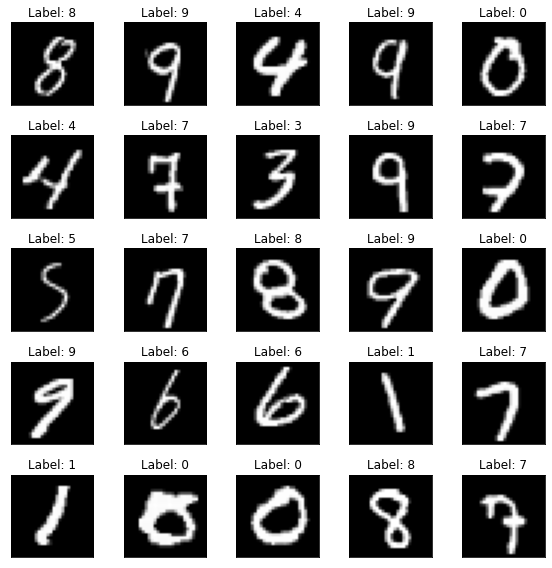

In [3]:
### Plot some sample
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(train_dataset)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

# Noise Addition

In [4]:
class noise(object):
    def __call__(self, image):
        noise_factor=0.2
        noisy_img = image + noise_factor * torch.randn(image.shape)
        #clip the image
        noisy_img = np.clip(noisy_img, 0., 1.)
        return (image,noisy_img)

# Prepare Dataset

In [5]:
# In this case the train_transform and test_transform are the same, but we keep them separate for potential future updates
train_transform = transforms.Compose([transforms.ToTensor(), noise(),])
val_transform = transforms.Compose([transforms.ToTensor(), noise(),])
test_transform = transforms.Compose([transforms.ToTensor(), noise(),])

In [6]:
# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform

In [7]:
### Define train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
### Define test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

#  Convolutional Autoencoder

In [8]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim, lin_layer):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(32, 64, 3, stride=2, padding=0),
            nn.ReLU(True),
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(3 * 3 * 64, lin_layer),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(lin_layer, encoded_space_dim)
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.encoder_lin(x)
        return x

In [9]:
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim, lin_layer):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(encoded_space_dim, lin_layer),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(lin_layer, 3 * 3 * 64),
            nn.ReLU(True),
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(64, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(64, 32, 3, stride=2, output_padding=0),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

**Check Device**

In [10]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

### Set the random seed for reproducible results
torch.manual_seed(0)

Training device: cuda


**Define Training**

In [11]:
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer,noise=False):
    # Train the encoder and decoder
    encoder.train()
    decoder.train()
    # Iterate the dataloader 
    for image_batch, _ in dataloader:
        
        image= image_batch[0].to(device)
        
        noisy=image    
        if noise: 
            noisy=image_batch[1].to(device)

        # Encode data
        encoded_data = encoder(noisy)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image)        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss.data

**Define Test**

In [12]:
def test_epoch(encoder, decoder, device, dataloader, loss_fn,noise=False):
    # Evaluate the encoder and decoder
    encoder.eval()
    decoder.eval()
    # Do not track gradients
    with torch.no_grad(): 
        # Store the outputs for each batch
        output = []
        label = []
        for image_batch, _ in dataloader:
            image= image_batch[0].to(device)
        
            noisy=image           
            if noise: 
                noisy=image_batch[1].to(device)
                
            # Encode data
            encoded_data = encoder(noisy)            
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            output.append(decoded_data.cpu())
            label.append(image.cpu())

        # Concatenate the given sequence
        output = torch.cat(output)
        label = torch.cat(label) 
        # Validation loss
        val_loss = loss_fn(output, label)
    return val_loss.data

In [13]:
def training(num_epochs, early_stopping, encoder, decoder, 
             loss_fn, optim, train_dataloader, test_dataset, device, noise=False):
    train_loss_log = []
    val_loss_log = []

    max_early=float("-inf")
    idx_early=-1

    for epoch in range(num_epochs):
        # Training 
        train_loss=train_epoch(
            encoder=encoder, 
            decoder=decoder, 
            device=device, 
            dataloader=train_dataloader, 
            loss_fn=loss_fn, 
            optimizer=optim,
            noise=noise)
        
        train_loss_log.append(train_loss)
        print('TRAIN - EPOCH %d/%d - loss: %f' % (epoch + 1, num_epochs, train_loss))

        # Validation
        val_loss = test_epoch(
            encoder=encoder, 
            decoder=decoder, 
            device=device, 
            dataloader=test_dataloader, 
            loss_fn=loss_fn,
            noise=noise)
        val_loss_log.append(val_loss)
        print('VALIDATION - EPOCH %d/%d - loss: %f' % (epoch + 1, num_epochs, val_loss))

        # Get the output of a current image
        img = test_dataset[0][0][0].unsqueeze(0).to(device)
        if noise: img = test_dataset[0][0][1].unsqueeze(0).to(device)
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            rec_img  = decoder(encoder(img))

        # Plot original image and reconstructed image
        fig, axs = plt.subplots(1, 2, figsize=(12,6))
        axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        axs[0].set_title('Original image')
        axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
        axs[1].set_title('Reconstructed image')
        plt.tight_layout()
        plt.pause(0.1)

        #Early stopping:
        if idx_early==-1:
            idx_early=epoch
            max_early=val_loss
        elif round(float(val_loss), 4)<round(float(max_early), 4):
            idx_early=epoch
            max_early=val_loss
            
        elif epoch-idx_early>=early_stopping:
            print("STOPPED BY EARLY STOPPING")
            break
    
    return (train_loss_log,val_loss_log)

Total Combinations: 1

 Current Parameters: 0 (10, 128, 0.001, 1e-05)
TRAIN - EPOCH 1/40 - loss: 0.058238
VALIDATION - EPOCH 1/40 - loss: 0.057180


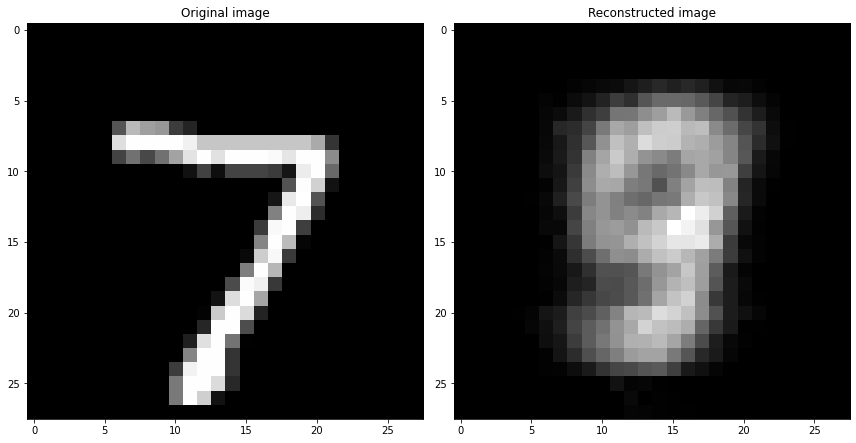

TRAIN - EPOCH 2/40 - loss: 0.032812
VALIDATION - EPOCH 2/40 - loss: 0.034842


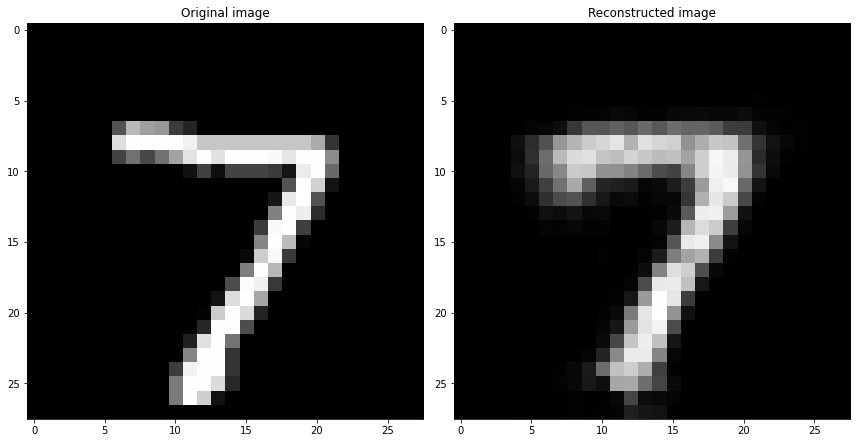

TRAIN - EPOCH 3/40 - loss: 0.024237
VALIDATION - EPOCH 3/40 - loss: 0.025407


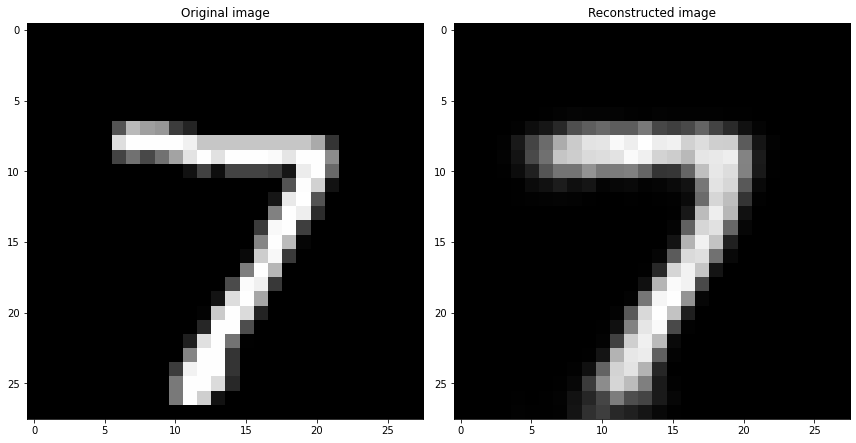

TRAIN - EPOCH 4/40 - loss: 0.020832
VALIDATION - EPOCH 4/40 - loss: 0.020858


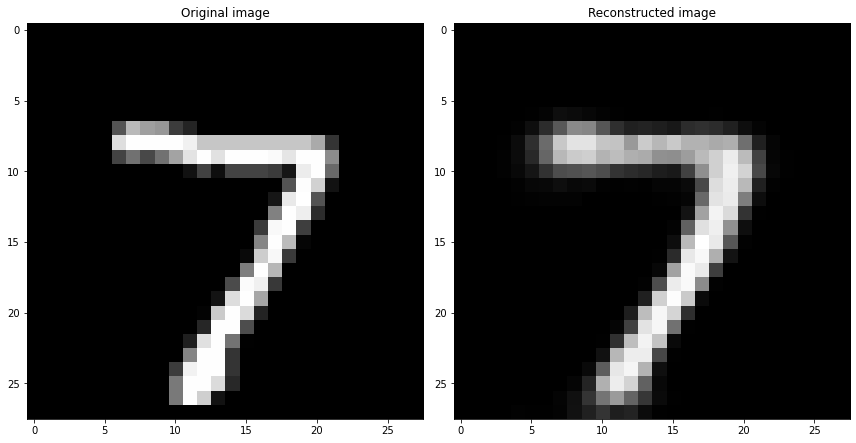

TRAIN - EPOCH 5/40 - loss: 0.018105
VALIDATION - EPOCH 5/40 - loss: 0.018884


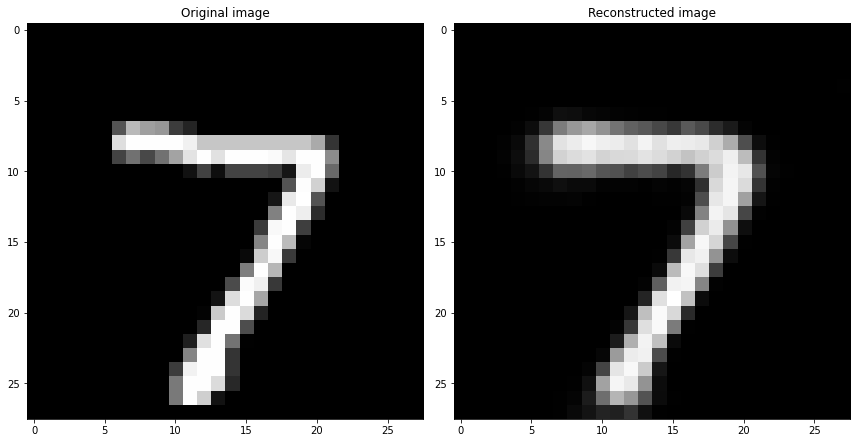

TRAIN - EPOCH 6/40 - loss: 0.018980
VALIDATION - EPOCH 6/40 - loss: 0.017510


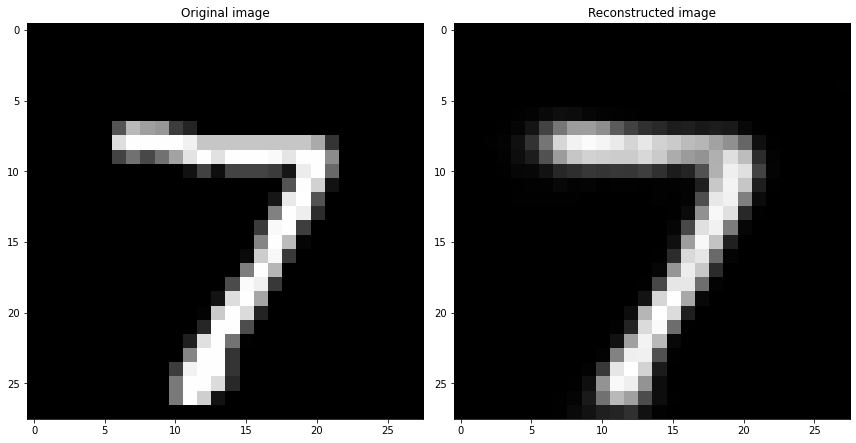

TRAIN - EPOCH 7/40 - loss: 0.016056
VALIDATION - EPOCH 7/40 - loss: 0.016783


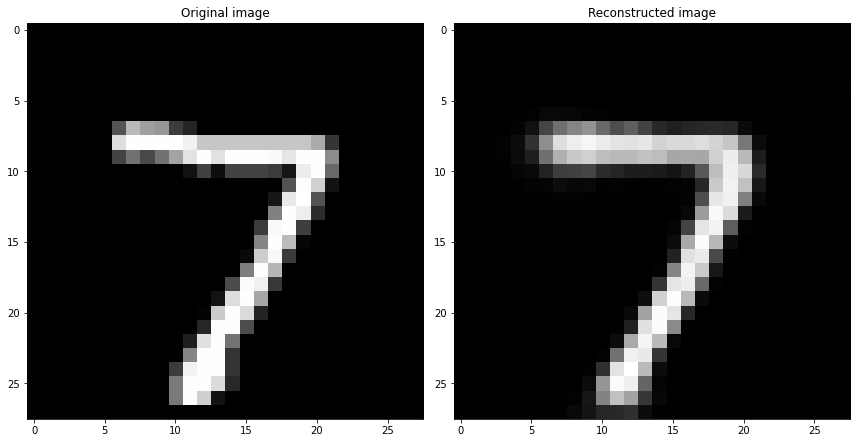

TRAIN - EPOCH 8/40 - loss: 0.015712
VALIDATION - EPOCH 8/40 - loss: 0.016097


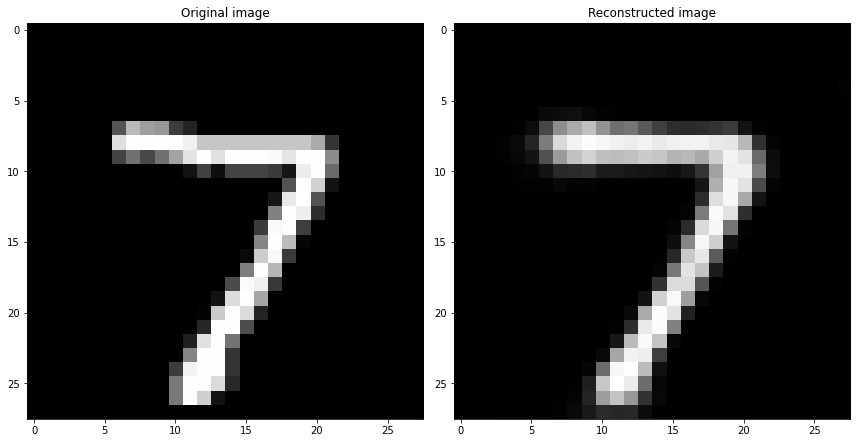

TRAIN - EPOCH 9/40 - loss: 0.016948
VALIDATION - EPOCH 9/40 - loss: 0.015617


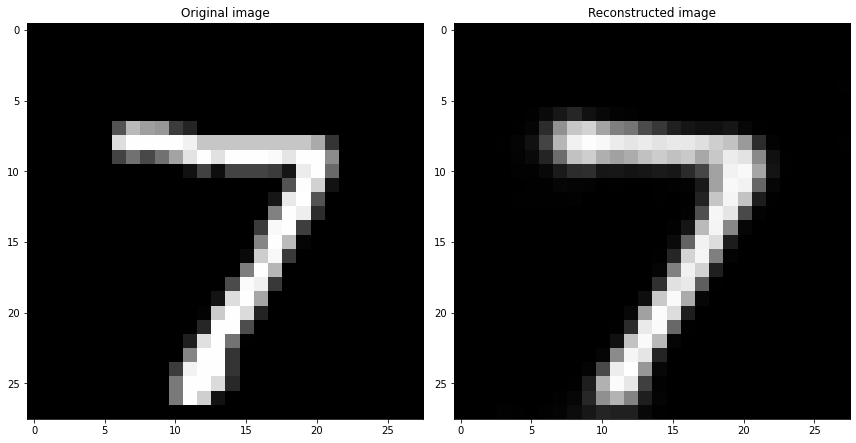

TRAIN - EPOCH 10/40 - loss: 0.013843
VALIDATION - EPOCH 10/40 - loss: 0.015138


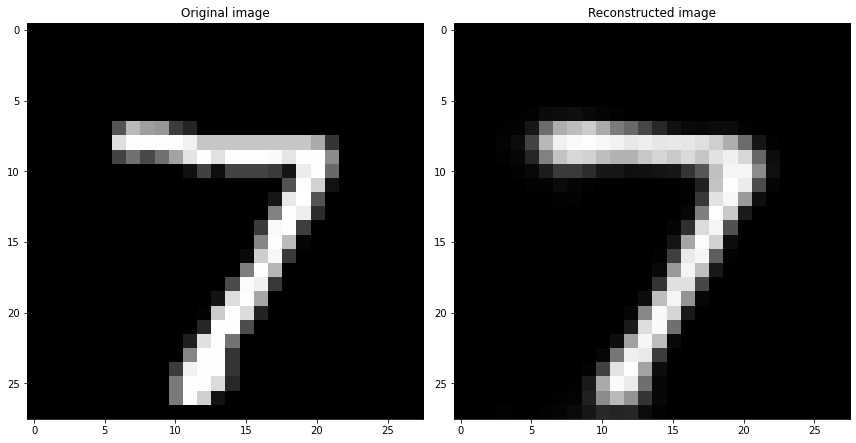

TRAIN - EPOCH 11/40 - loss: 0.014068
VALIDATION - EPOCH 11/40 - loss: 0.014998


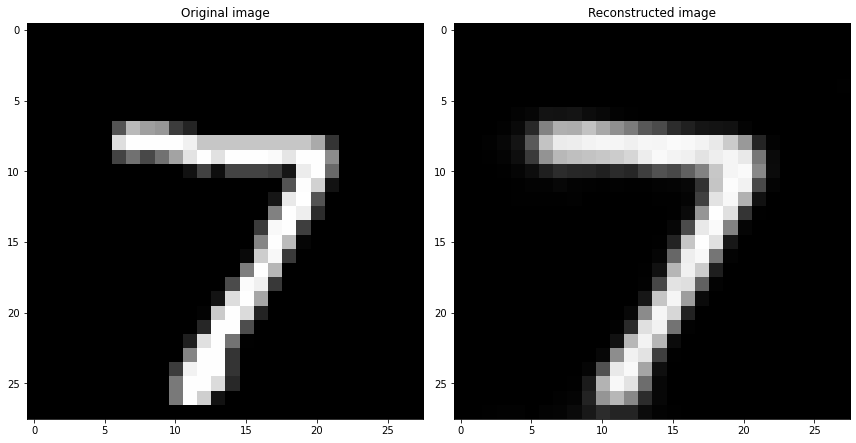

TRAIN - EPOCH 12/40 - loss: 0.014838
VALIDATION - EPOCH 12/40 - loss: 0.014740


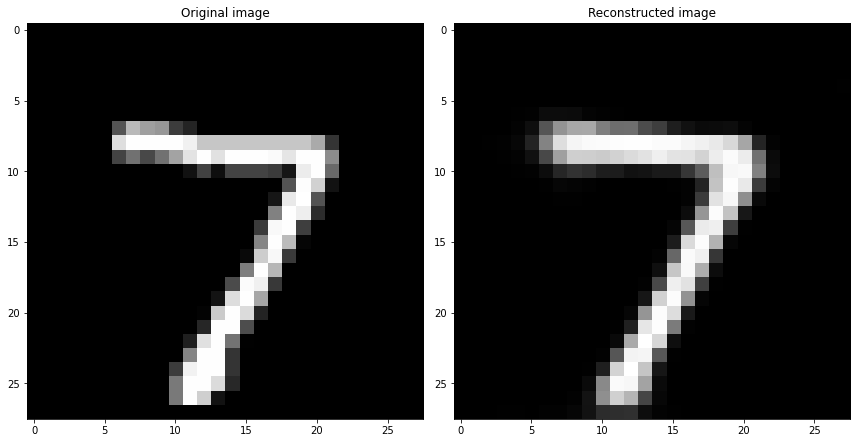

TRAIN - EPOCH 13/40 - loss: 0.015215
VALIDATION - EPOCH 13/40 - loss: 0.014372


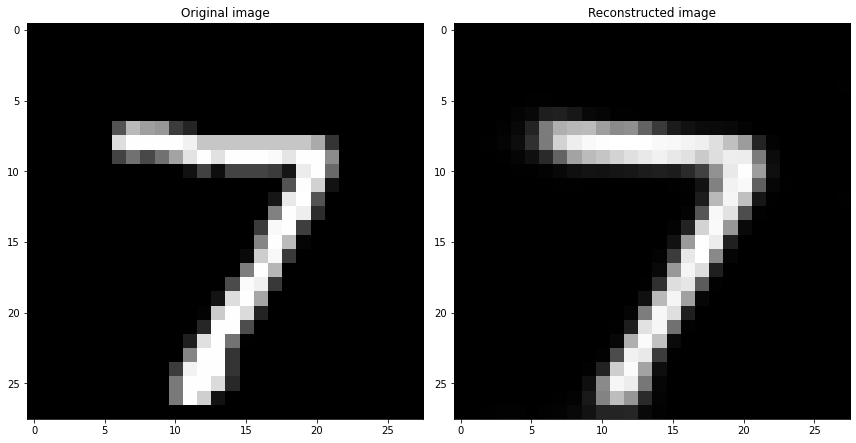

TRAIN - EPOCH 14/40 - loss: 0.014881
VALIDATION - EPOCH 14/40 - loss: 0.014313


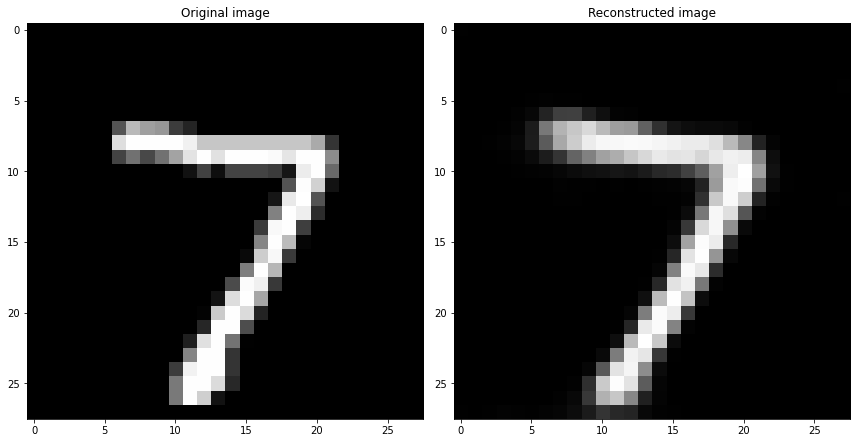

TRAIN - EPOCH 15/40 - loss: 0.014946
VALIDATION - EPOCH 15/40 - loss: 0.014019


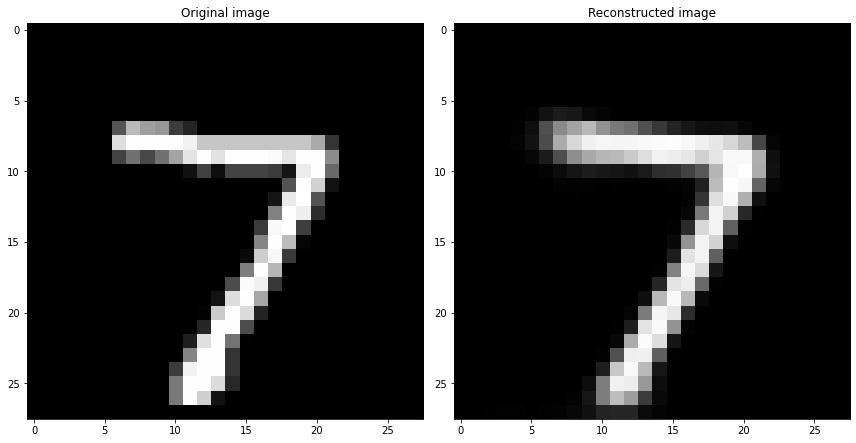

TRAIN - EPOCH 16/40 - loss: 0.012888
VALIDATION - EPOCH 16/40 - loss: 0.013632


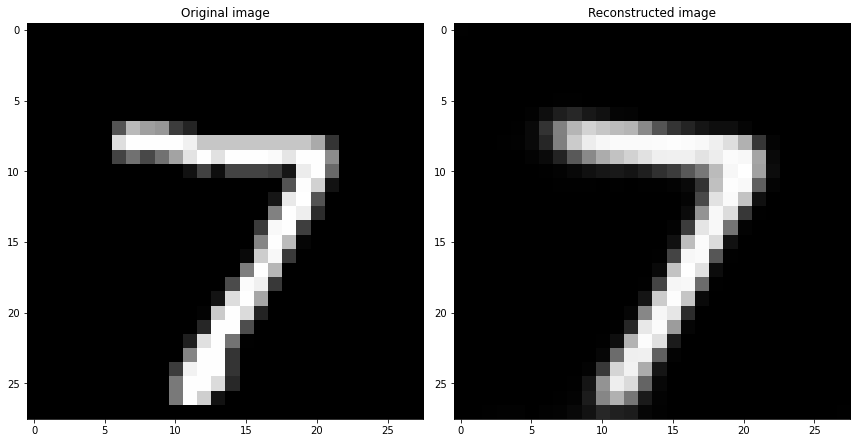

TRAIN - EPOCH 17/40 - loss: 0.015643
VALIDATION - EPOCH 17/40 - loss: 0.013424


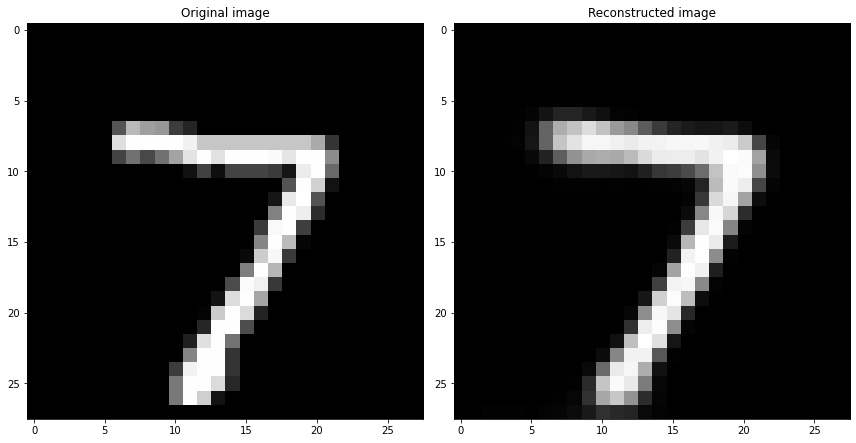

TRAIN - EPOCH 18/40 - loss: 0.013297
VALIDATION - EPOCH 18/40 - loss: 0.013369


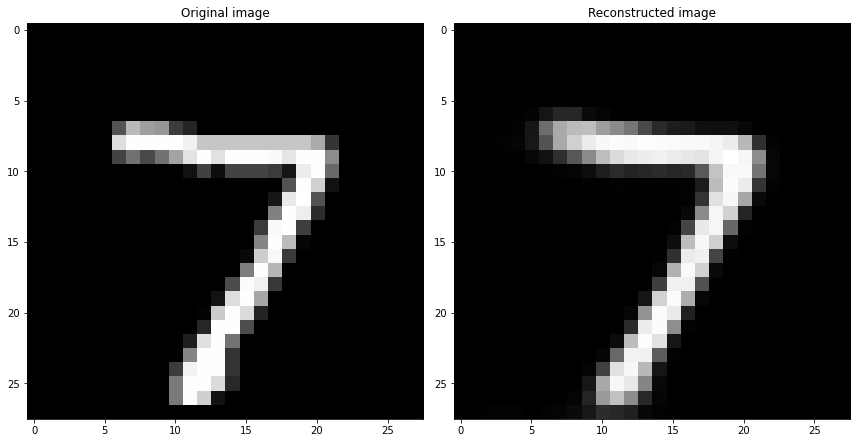

TRAIN - EPOCH 19/40 - loss: 0.012145
VALIDATION - EPOCH 19/40 - loss: 0.013400


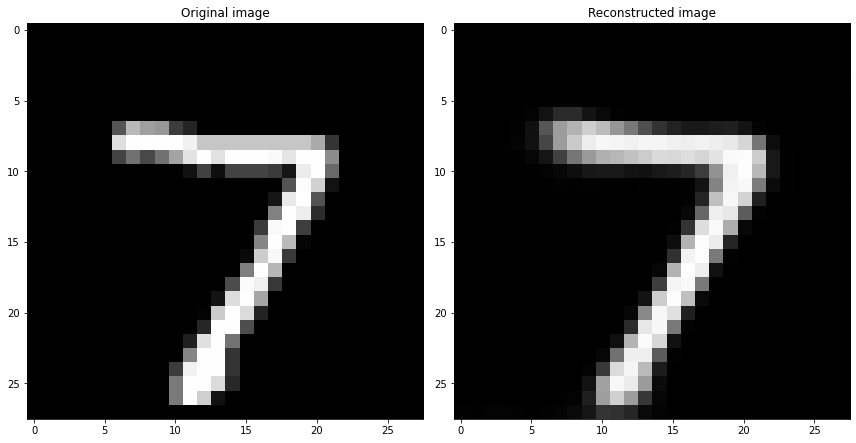

TRAIN - EPOCH 20/40 - loss: 0.012631
VALIDATION - EPOCH 20/40 - loss: 0.013191


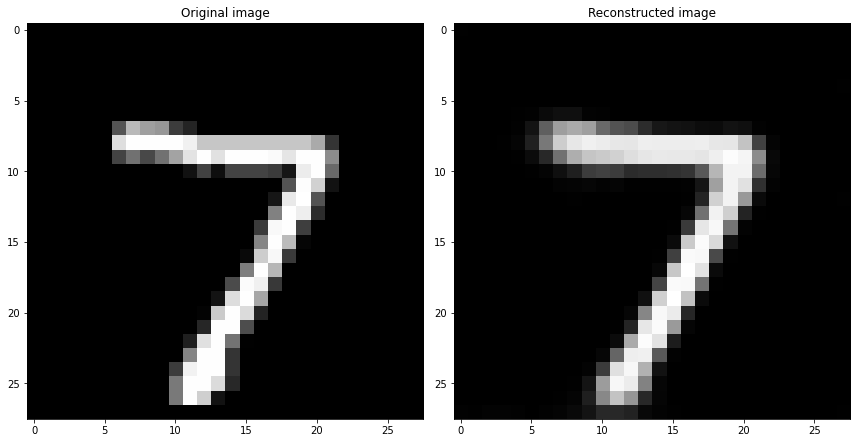

TRAIN - EPOCH 21/40 - loss: 0.012919
VALIDATION - EPOCH 21/40 - loss: 0.013131


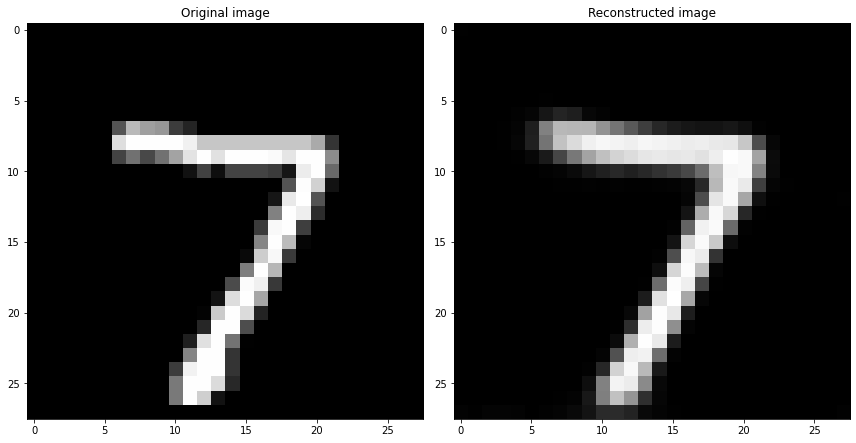

TRAIN - EPOCH 22/40 - loss: 0.013139
VALIDATION - EPOCH 22/40 - loss: 0.012876


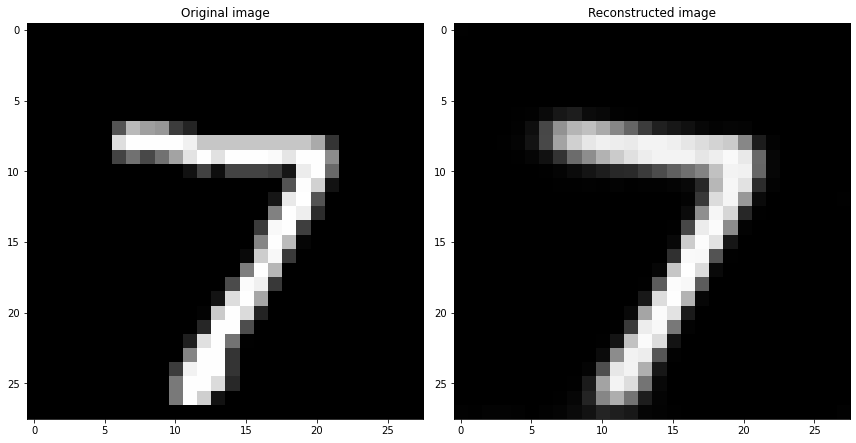

TRAIN - EPOCH 23/40 - loss: 0.013066
VALIDATION - EPOCH 23/40 - loss: 0.012869


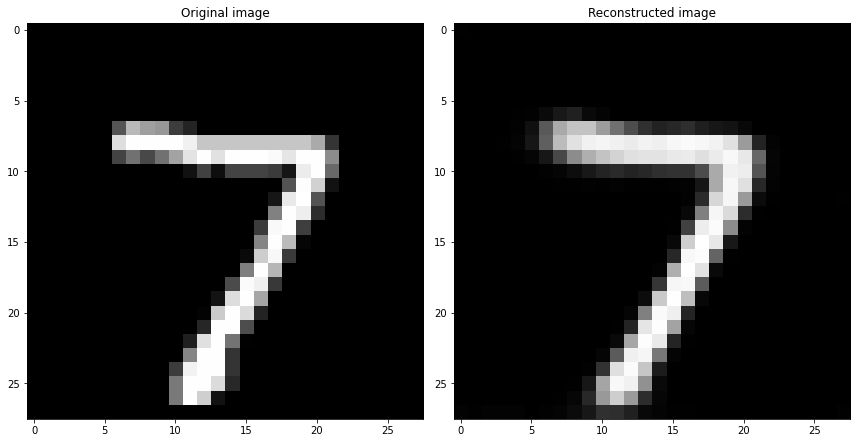

TRAIN - EPOCH 24/40 - loss: 0.012643
VALIDATION - EPOCH 24/40 - loss: 0.012743


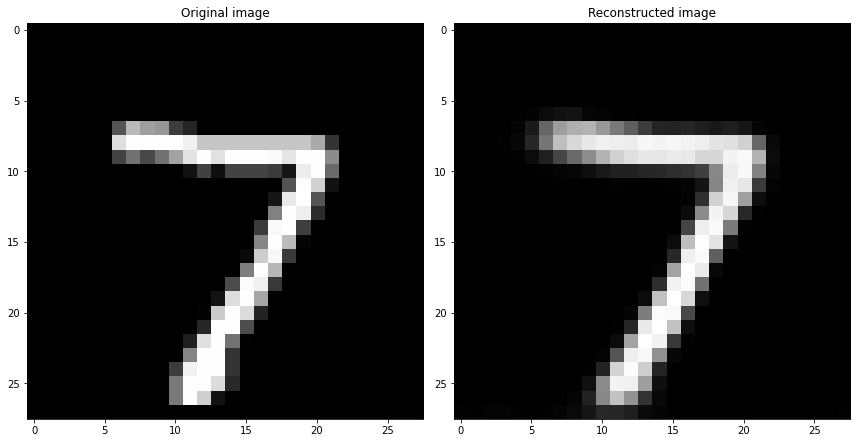

TRAIN - EPOCH 25/40 - loss: 0.011768
VALIDATION - EPOCH 25/40 - loss: 0.012727


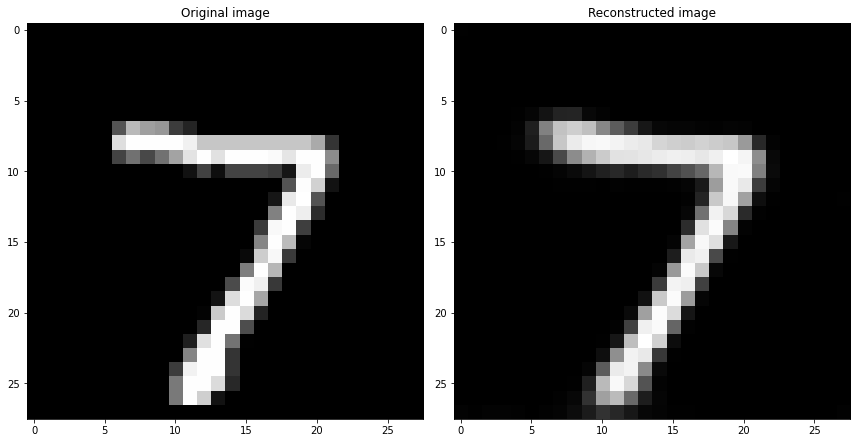

TRAIN - EPOCH 26/40 - loss: 0.011166
VALIDATION - EPOCH 26/40 - loss: 0.012453


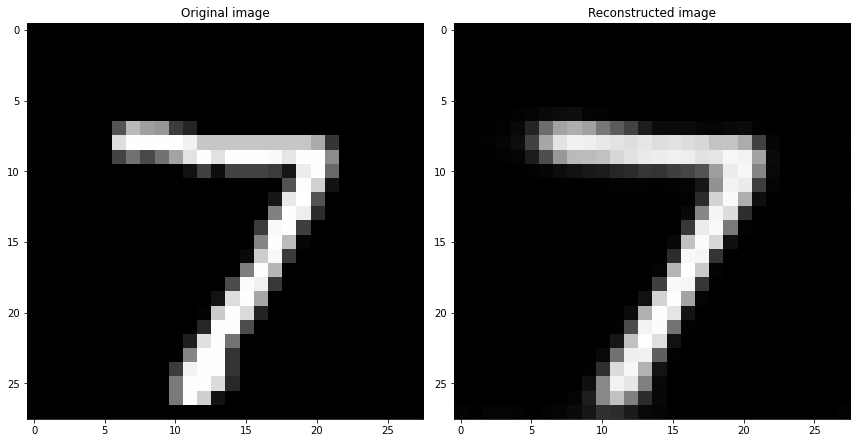

TRAIN - EPOCH 27/40 - loss: 0.014481
VALIDATION - EPOCH 27/40 - loss: 0.012425


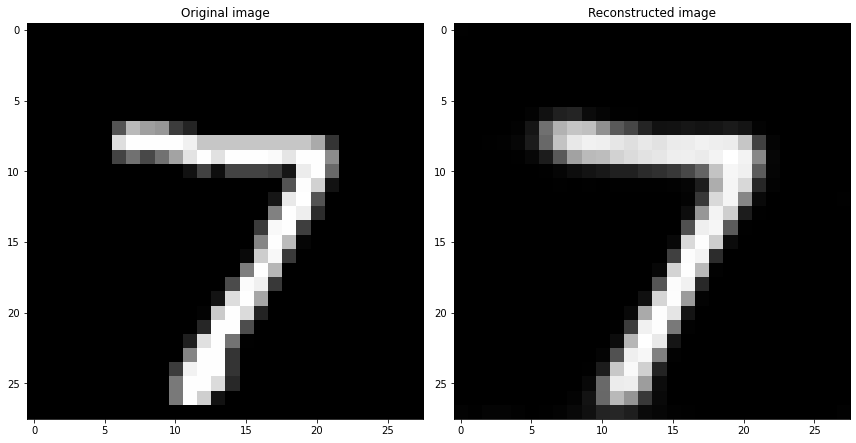

TRAIN - EPOCH 28/40 - loss: 0.012298
VALIDATION - EPOCH 28/40 - loss: 0.012382


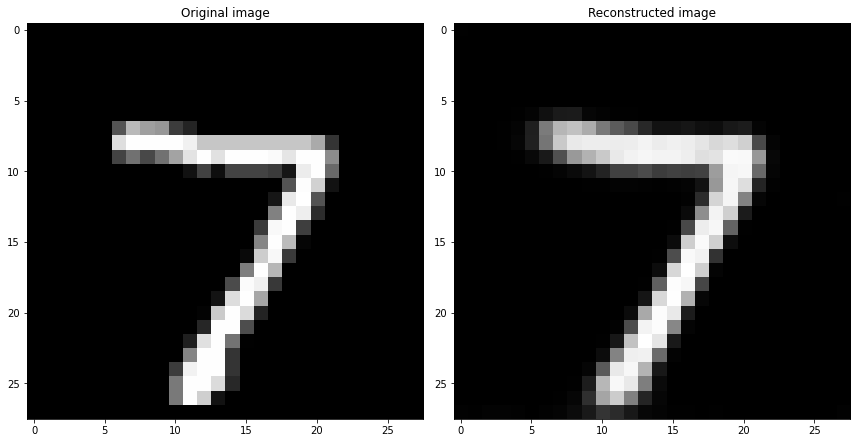

TRAIN - EPOCH 29/40 - loss: 0.012143
VALIDATION - EPOCH 29/40 - loss: 0.012475


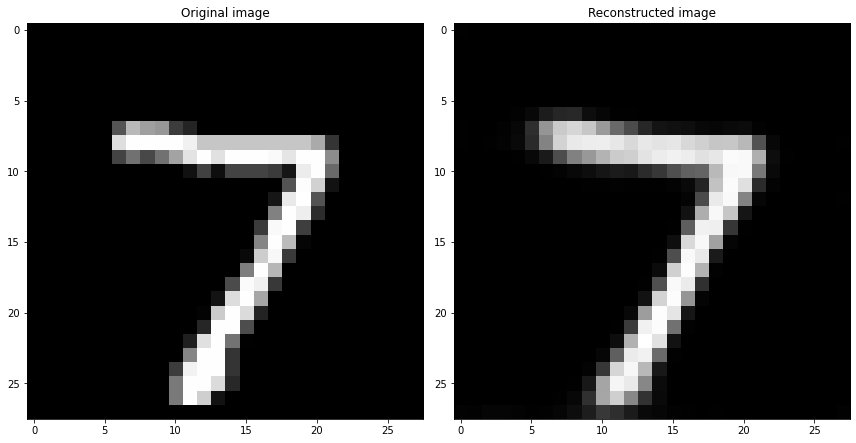

TRAIN - EPOCH 30/40 - loss: 0.012278
VALIDATION - EPOCH 30/40 - loss: 0.012212


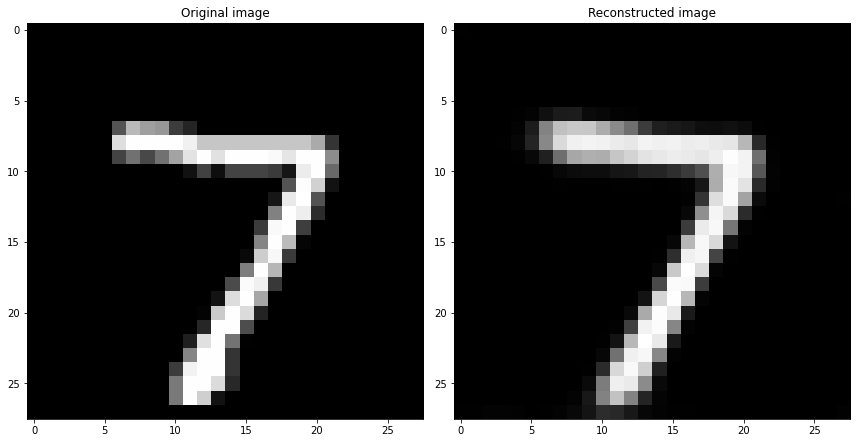

TRAIN - EPOCH 31/40 - loss: 0.012271
VALIDATION - EPOCH 31/40 - loss: 0.012091


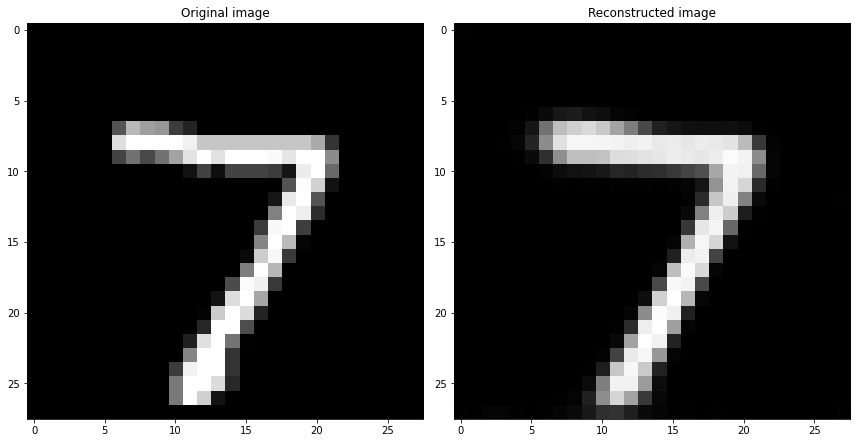

TRAIN - EPOCH 32/40 - loss: 0.011891
VALIDATION - EPOCH 32/40 - loss: 0.012243


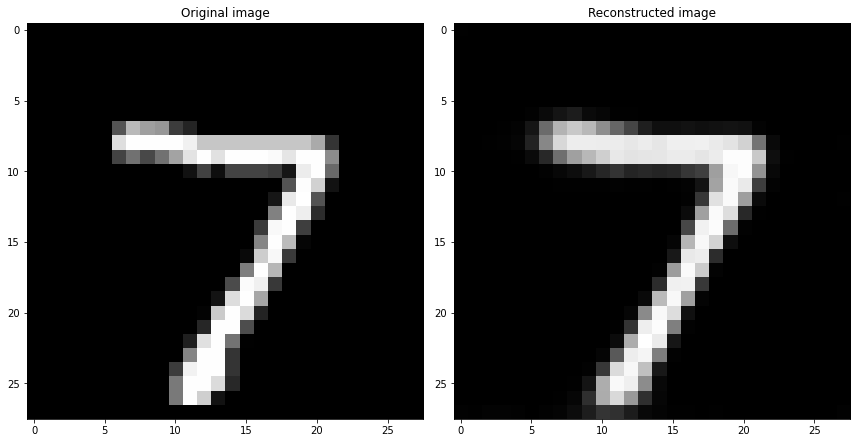

TRAIN - EPOCH 33/40 - loss: 0.012639
VALIDATION - EPOCH 33/40 - loss: 0.012096


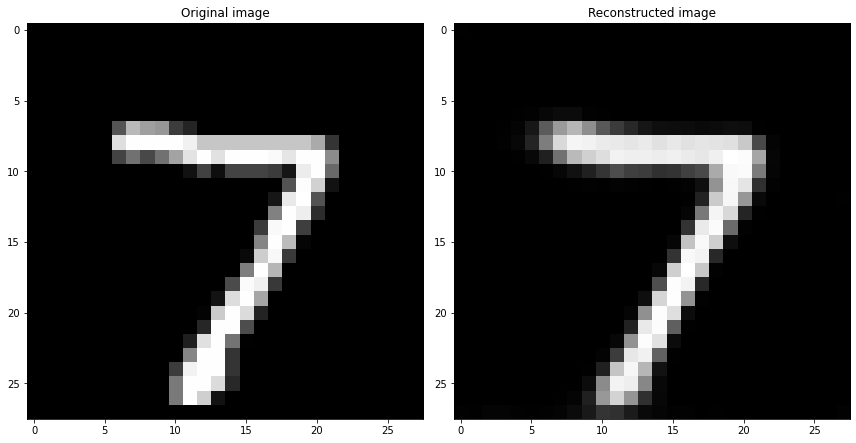

TRAIN - EPOCH 34/40 - loss: 0.011111
VALIDATION - EPOCH 34/40 - loss: 0.012024


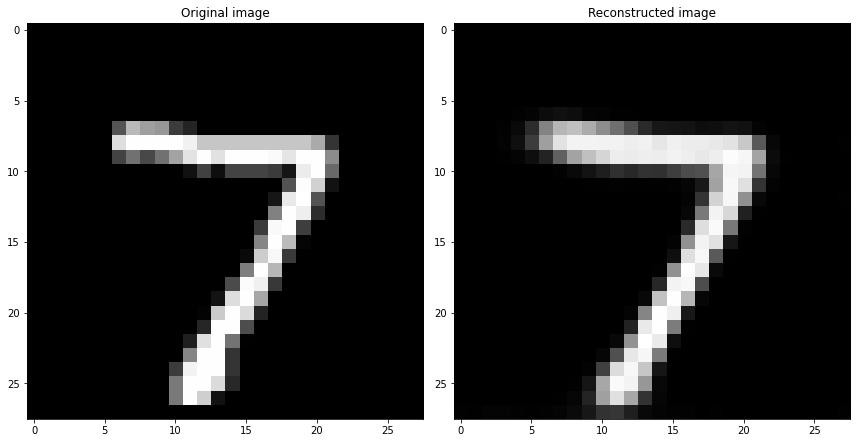

TRAIN - EPOCH 35/40 - loss: 0.011963
VALIDATION - EPOCH 35/40 - loss: 0.012023


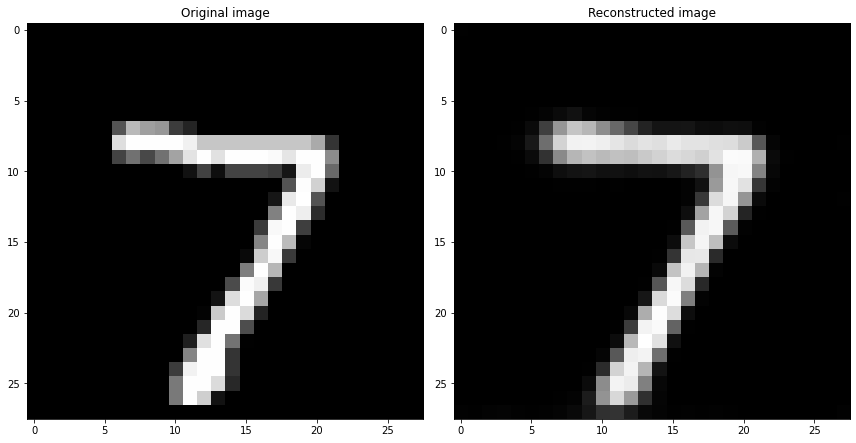

TRAIN - EPOCH 36/40 - loss: 0.011885
VALIDATION - EPOCH 36/40 - loss: 0.012065


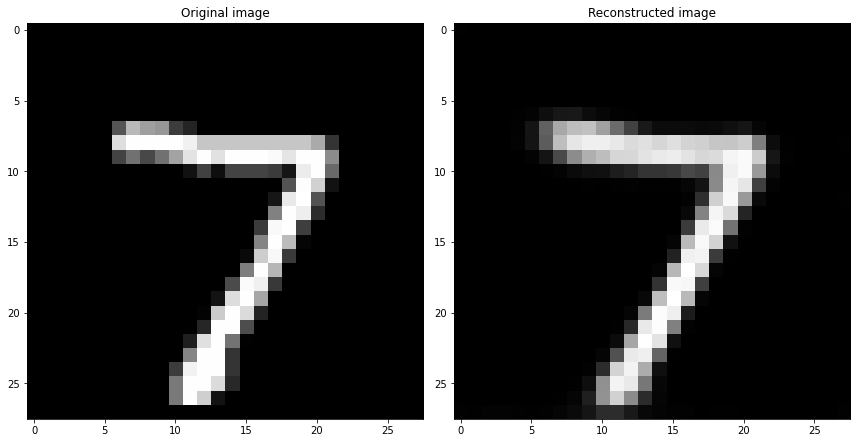

TRAIN - EPOCH 37/40 - loss: 0.012476
VALIDATION - EPOCH 37/40 - loss: 0.011843


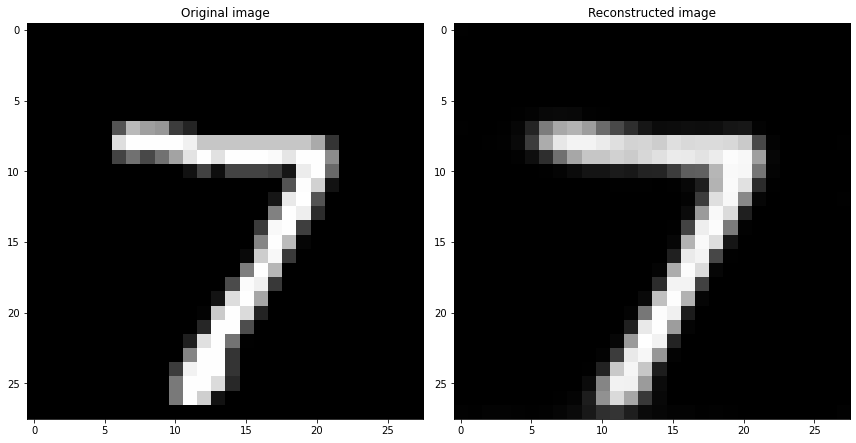

TRAIN - EPOCH 38/40 - loss: 0.011917
VALIDATION - EPOCH 38/40 - loss: 0.011792


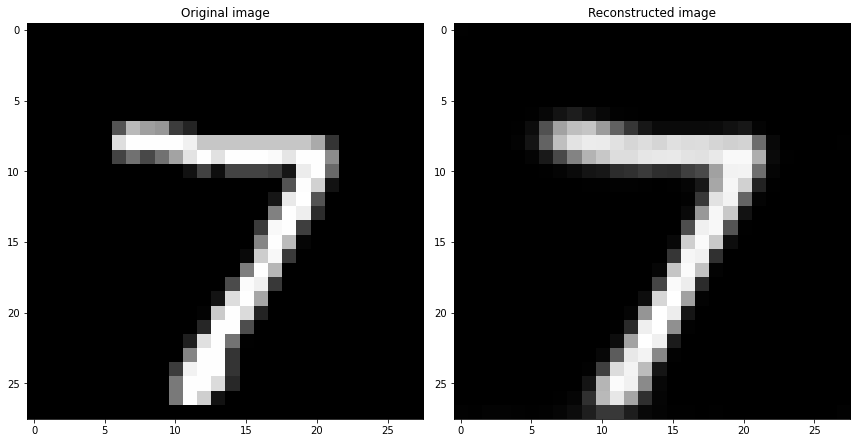

TRAIN - EPOCH 39/40 - loss: 0.011845
VALIDATION - EPOCH 39/40 - loss: 0.011733


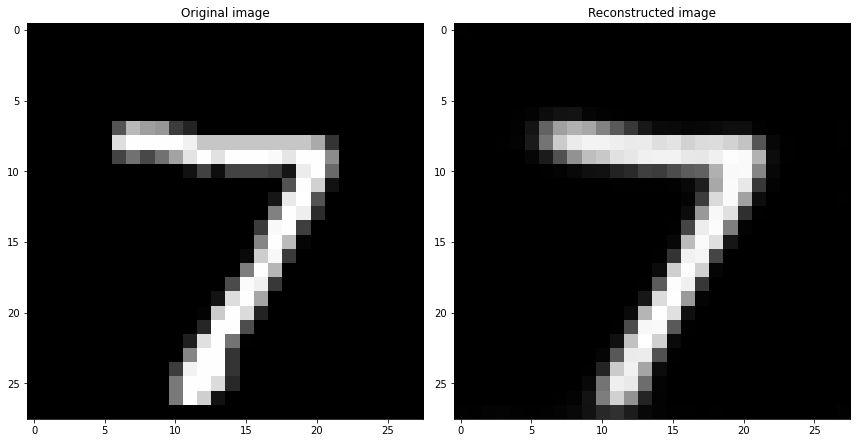

TRAIN - EPOCH 40/40 - loss: 0.011625
VALIDATION - EPOCH 40/40 - loss: 0.011753


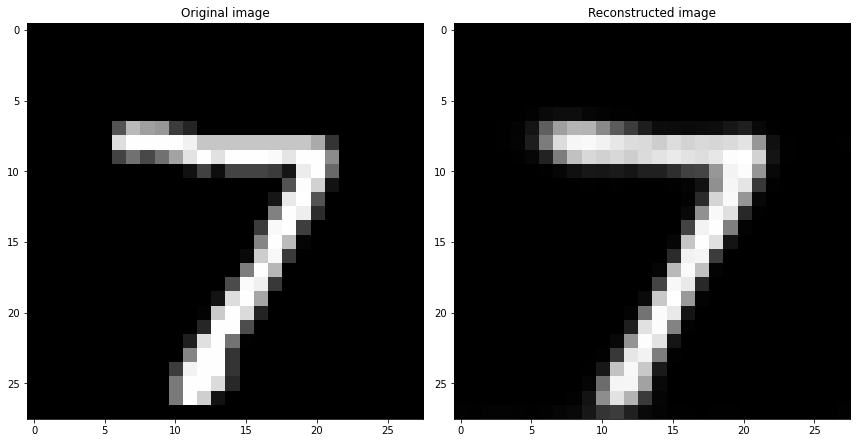

	Train Loss: 0.012 	Val Loss: 0.012


Best Model: (10, 128, 0.001, 1e-05)


In [14]:
'''
Best Parameters

encoded_space_dim = 10
lin_layer= 128
learning_rate= 1e-3
l2= 1e-5

'''

num_epochs = 40
early_stopping = 5
encoded_space_dim = [10]
lin_layer = [128]
learning_rate = [1e-3]
l2 = [1e-5]

hyperparams = [encoded_space_dim, lin_layer, learning_rate, l2]  

current_parameters=[]
import itertools
for hyper in itertools.product(*hyperparams):
    current_parameters.append(hyper)
print("Total Combinations:",len(current_parameters))


best_hyper=None
best_loss=None
for i,hyper in enumerate(current_parameters):
    print("\n Current Parameters:",i,hyper)
    encoded_space_dim, lin_layer, learning_rate, l2=hyper
    
    ### Initialize the two networks
    encoder = Encoder(encoded_space_dim=encoded_space_dim, lin_layer=lin_layer)
    decoder = Decoder(encoded_space_dim=encoded_space_dim, lin_layer=lin_layer)

    # Define the loss function
    loss_fn = torch.nn.MSELoss()

    # Define an optimizer
    params_to_optimize = [
        {'params': encoder.parameters()},
        {'params': decoder.parameters()}]

    optim = torch.optim.Adam(params_to_optimize, lr=learning_rate, weight_decay=l2)

    # Move to the device
    encoder.to(device)
    decoder.to(device)
    
    
    # Training phase
    train_loss_log,val_loss_log=training(num_epochs,
                                           early_stopping,
                                           encoder,
                                           decoder,
                                           loss_fn,
                                           optim,
                                           train_dataloader,
                                           test_dataset,
                                           device,
                                           noise=False)
    
    train_loss=train_loss_log[-1]
    val_loss=val_loss_log[-1]
    print("\tTrain Loss:",round(float(train_loss),3),"\tVal Loss:",round(float(val_loss),3))
    
    if not best_loss or val_loss<best_loss:
        best_loss=val_loss
        best_hyper=hyper

        
print("\n\nBest Model:",best_hyper)

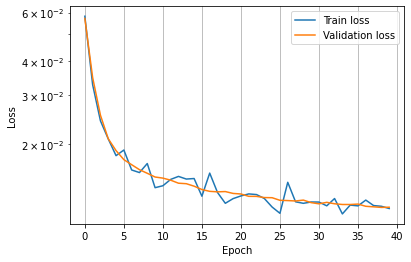

In [15]:
# Plot loss
plt.figure(figsize=(6,4))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(val_loss_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

In [16]:
test_loss = test_epoch(
            encoder=encoder, 
            decoder=decoder, 
            device=device, 
            dataloader=test_dataloader, 
            loss_fn=loss_fn,
            noise=False)

# Print losses
train_loss=train_loss_log[-1]
val_loss=val_loss_log[-1]

print("Train Loss:\t",round(float(train_loss), 4))
print("Val Loss:\t",round(float(val_loss), 4))
print("Test Loss:\t",round(float(test_loss), 4))

Train Loss:	 0.0116
Val Loss:	 0.0118
Test Loss:	 0.0118


# Denoising Convolutional Autoencoder

TRAIN - EPOCH 1/40 - loss: 0.059207
VALIDATION - EPOCH 1/40 - loss: 0.059431


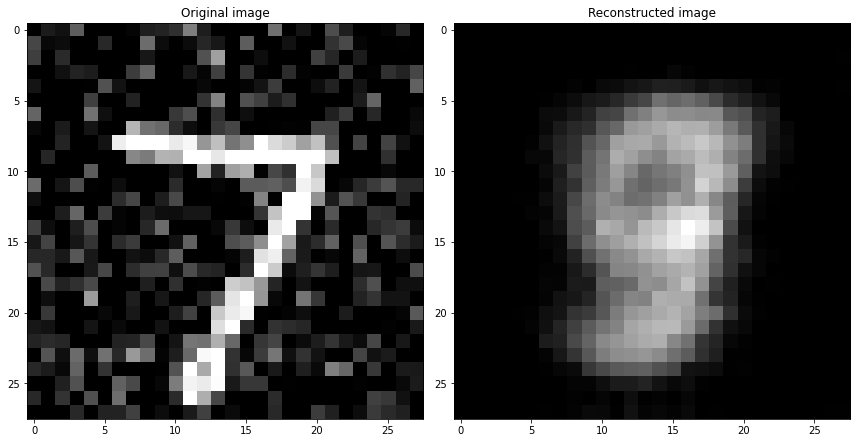

TRAIN - EPOCH 2/40 - loss: 0.033696
VALIDATION - EPOCH 2/40 - loss: 0.033807


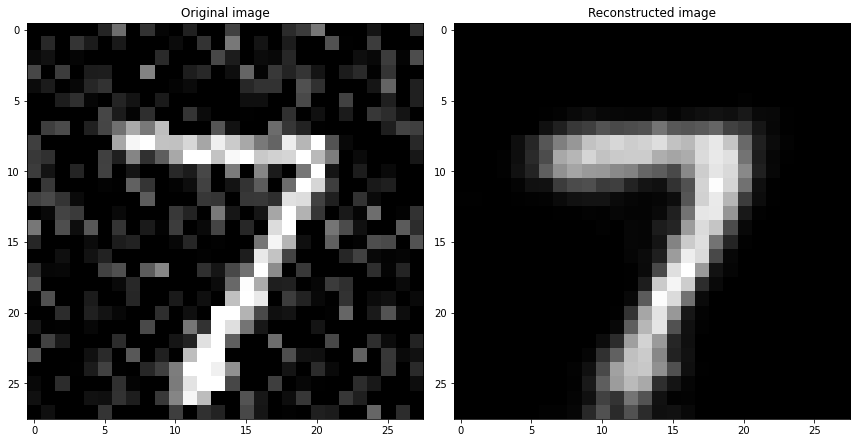

TRAIN - EPOCH 3/40 - loss: 0.024775
VALIDATION - EPOCH 3/40 - loss: 0.024221


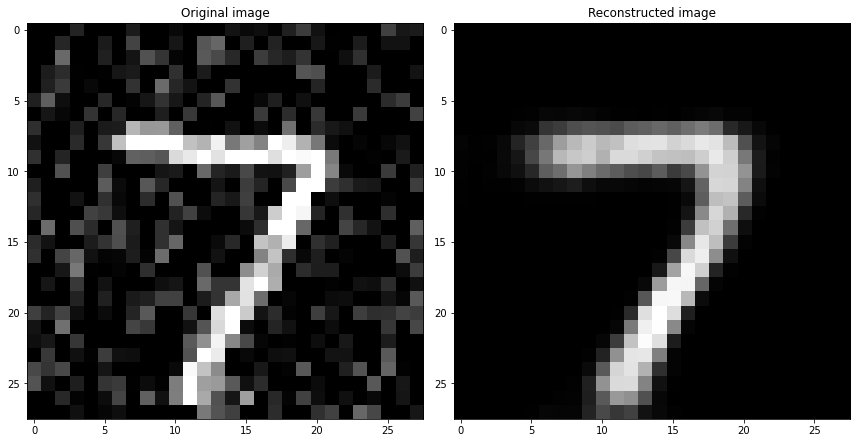

TRAIN - EPOCH 4/40 - loss: 0.018181
VALIDATION - EPOCH 4/40 - loss: 0.020125


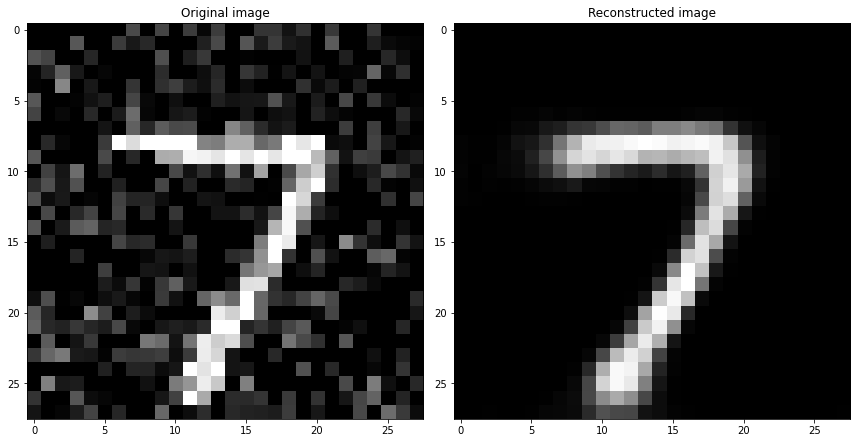

TRAIN - EPOCH 5/40 - loss: 0.018100
VALIDATION - EPOCH 5/40 - loss: 0.018619


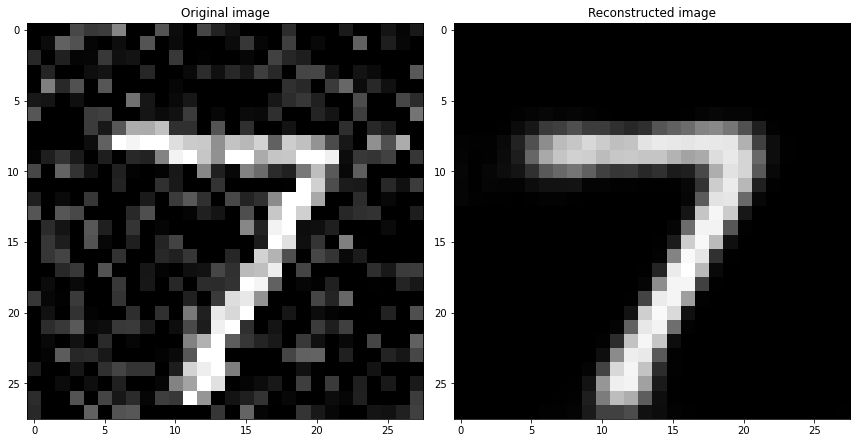

TRAIN - EPOCH 6/40 - loss: 0.016342
VALIDATION - EPOCH 6/40 - loss: 0.017515


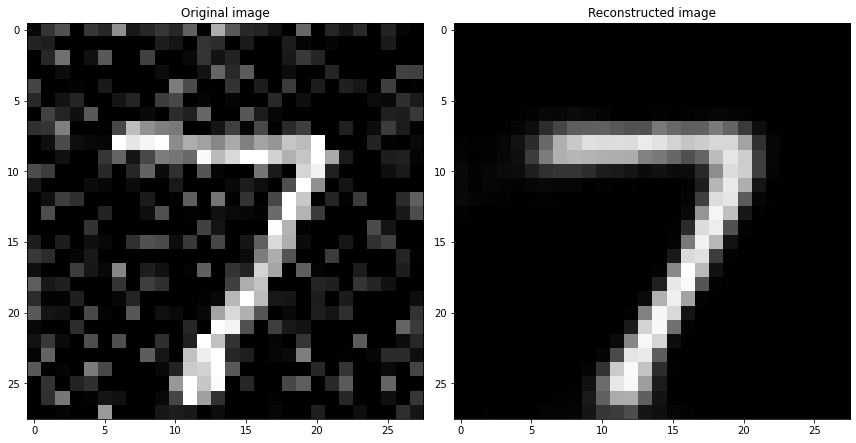

TRAIN - EPOCH 7/40 - loss: 0.015791
VALIDATION - EPOCH 7/40 - loss: 0.016733


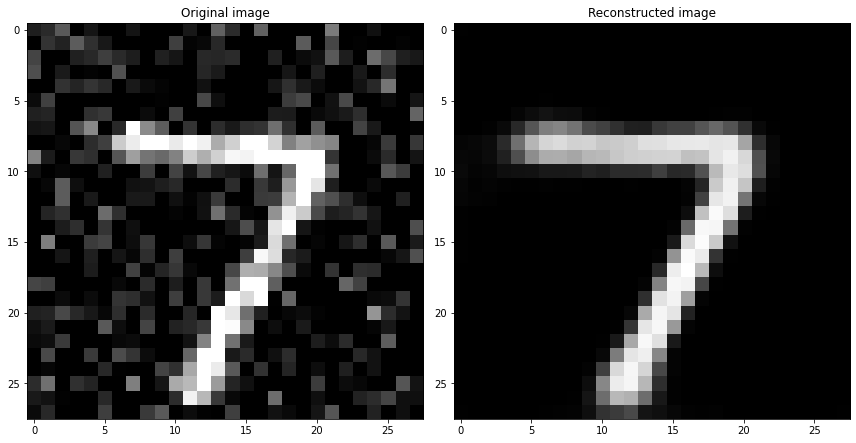

TRAIN - EPOCH 8/40 - loss: 0.017259
VALIDATION - EPOCH 8/40 - loss: 0.016050


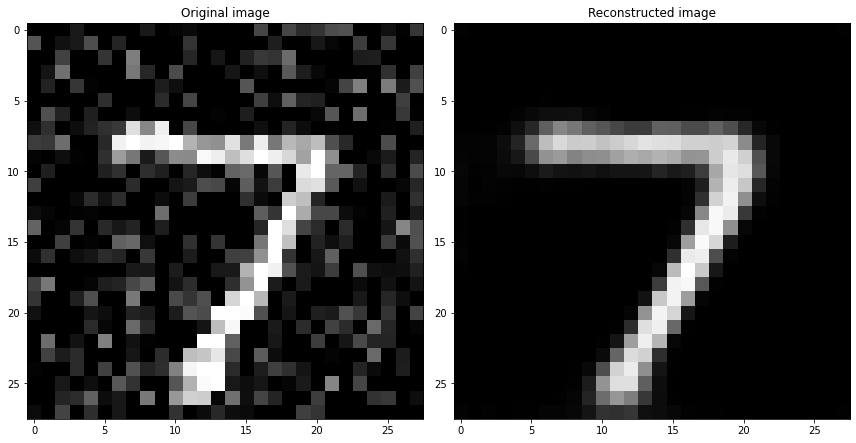

TRAIN - EPOCH 9/40 - loss: 0.015464
VALIDATION - EPOCH 9/40 - loss: 0.015728


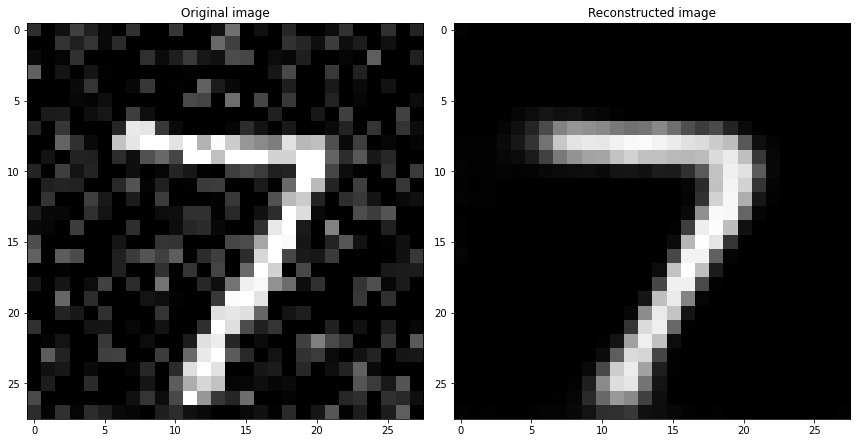

TRAIN - EPOCH 10/40 - loss: 0.015208
VALIDATION - EPOCH 10/40 - loss: 0.015204


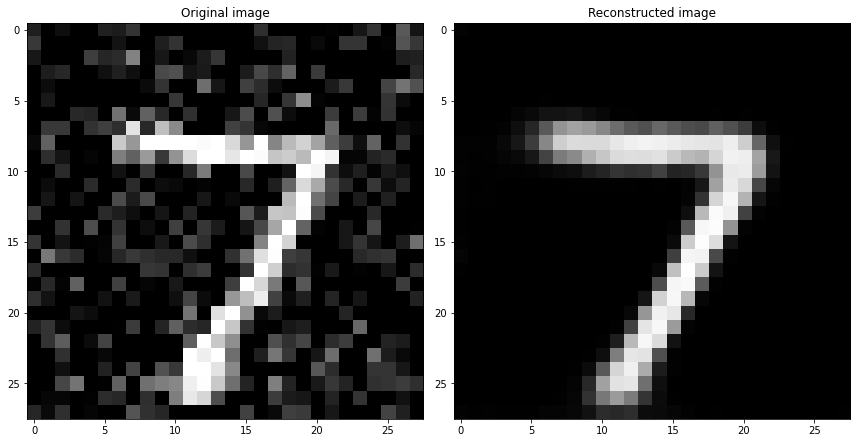

TRAIN - EPOCH 11/40 - loss: 0.015282
VALIDATION - EPOCH 11/40 - loss: 0.015045


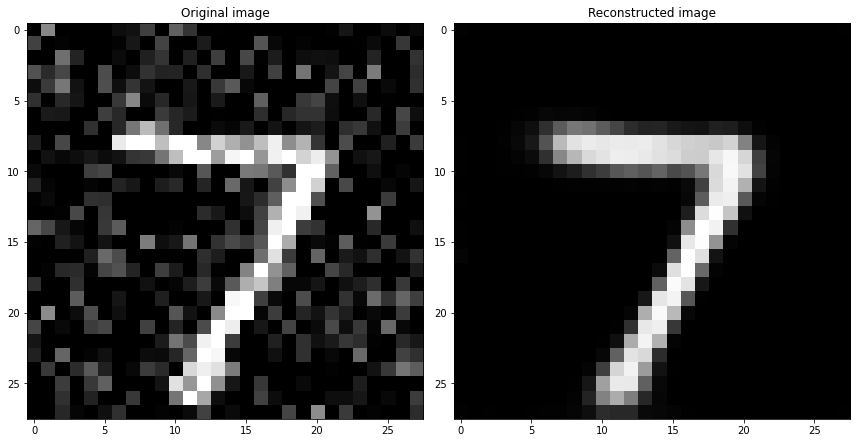

TRAIN - EPOCH 12/40 - loss: 0.014741
VALIDATION - EPOCH 12/40 - loss: 0.014690


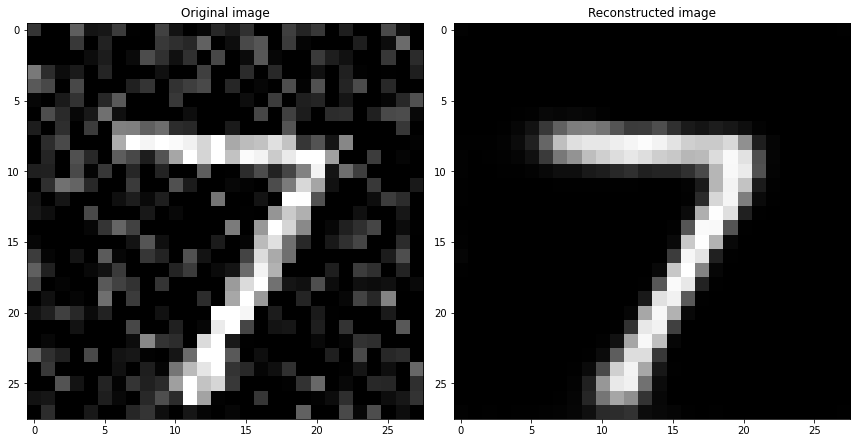

TRAIN - EPOCH 13/40 - loss: 0.014469
VALIDATION - EPOCH 13/40 - loss: 0.014503


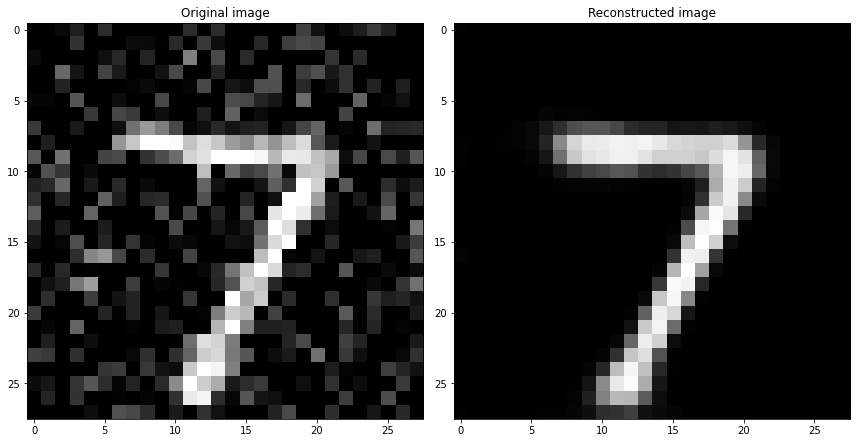

TRAIN - EPOCH 14/40 - loss: 0.014937
VALIDATION - EPOCH 14/40 - loss: 0.014197


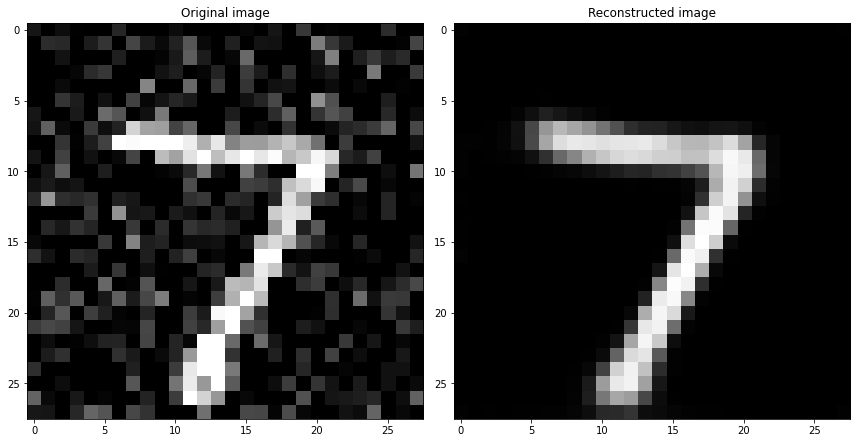

TRAIN - EPOCH 15/40 - loss: 0.012467
VALIDATION - EPOCH 15/40 - loss: 0.013971


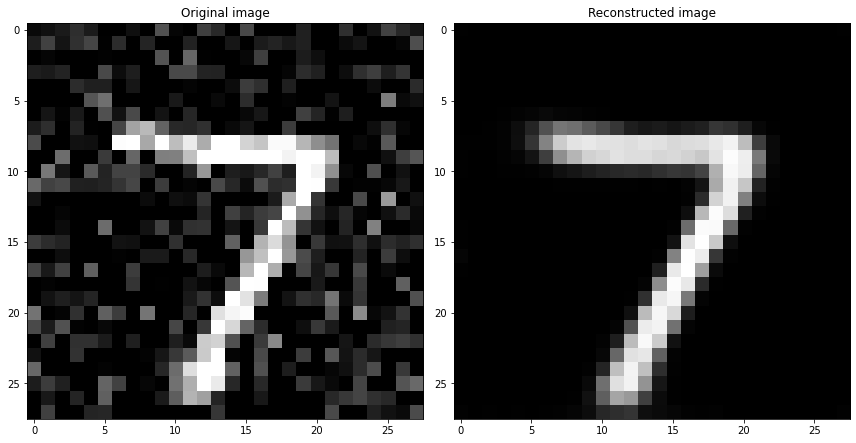

TRAIN - EPOCH 16/40 - loss: 0.014713
VALIDATION - EPOCH 16/40 - loss: 0.013943


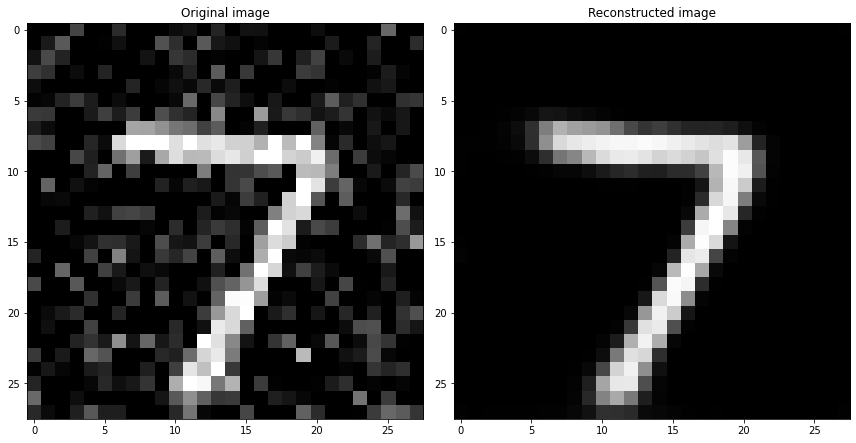

TRAIN - EPOCH 17/40 - loss: 0.013957
VALIDATION - EPOCH 17/40 - loss: 0.013709


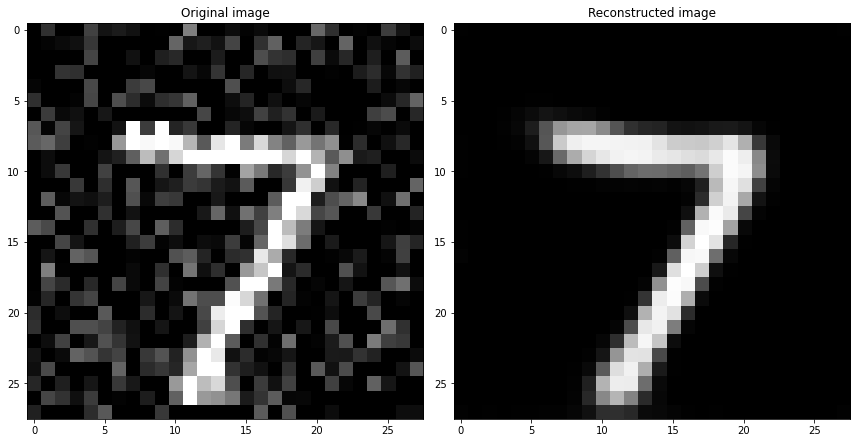

TRAIN - EPOCH 18/40 - loss: 0.012517
VALIDATION - EPOCH 18/40 - loss: 0.013695


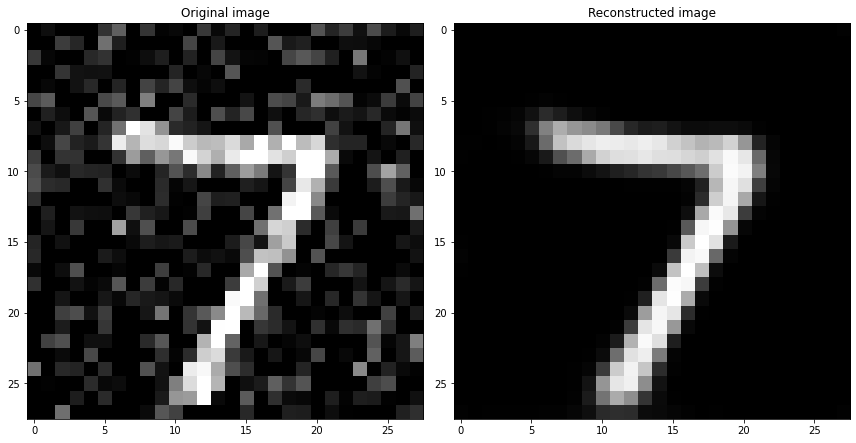

TRAIN - EPOCH 19/40 - loss: 0.015869
VALIDATION - EPOCH 19/40 - loss: 0.013427


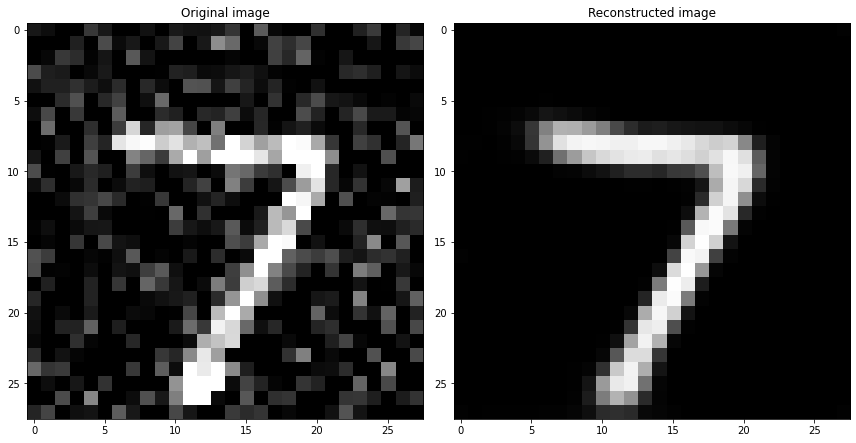

TRAIN - EPOCH 20/40 - loss: 0.013031
VALIDATION - EPOCH 20/40 - loss: 0.013310


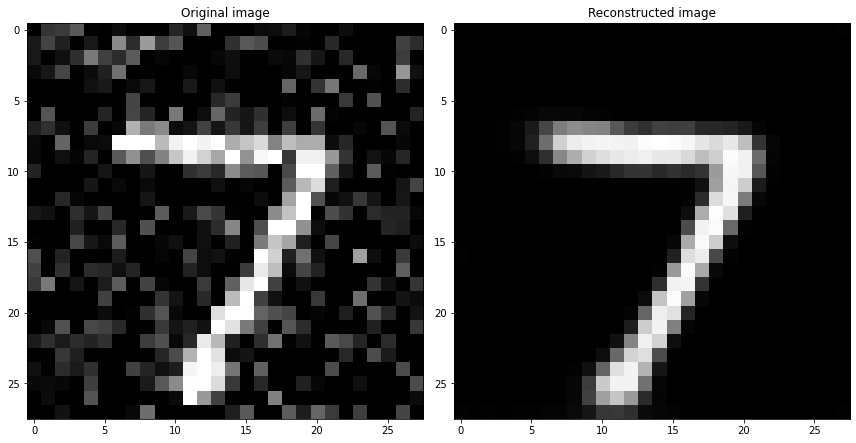

TRAIN - EPOCH 21/40 - loss: 0.012540
VALIDATION - EPOCH 21/40 - loss: 0.013320


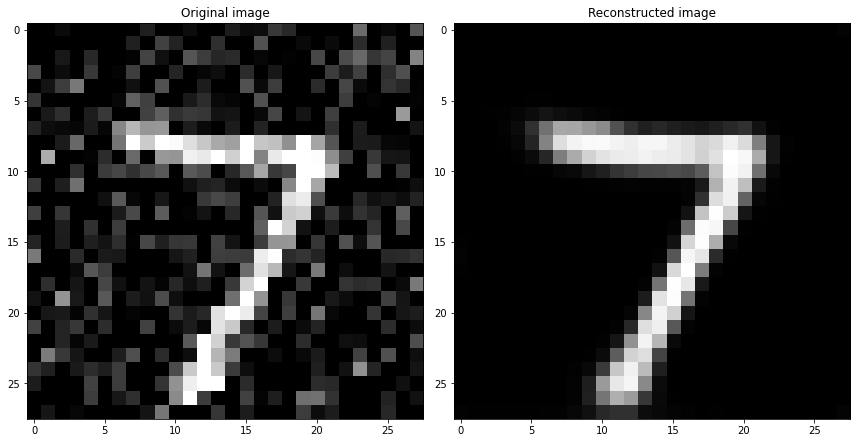

TRAIN - EPOCH 22/40 - loss: 0.012762
VALIDATION - EPOCH 22/40 - loss: 0.013051


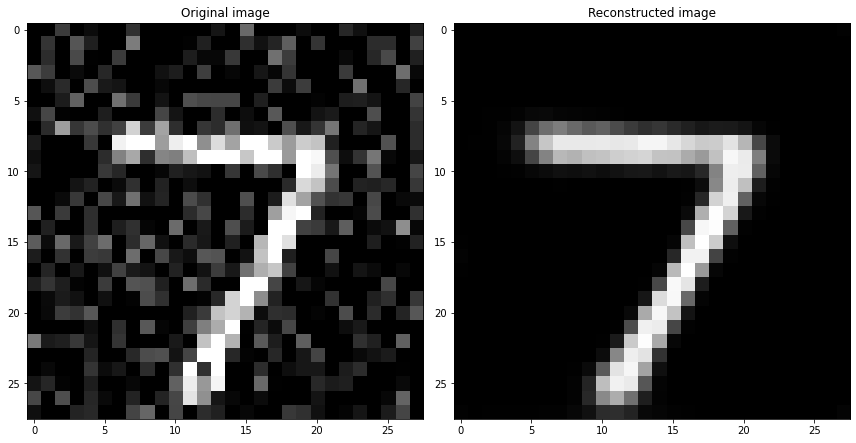

TRAIN - EPOCH 23/40 - loss: 0.012096
VALIDATION - EPOCH 23/40 - loss: 0.012932


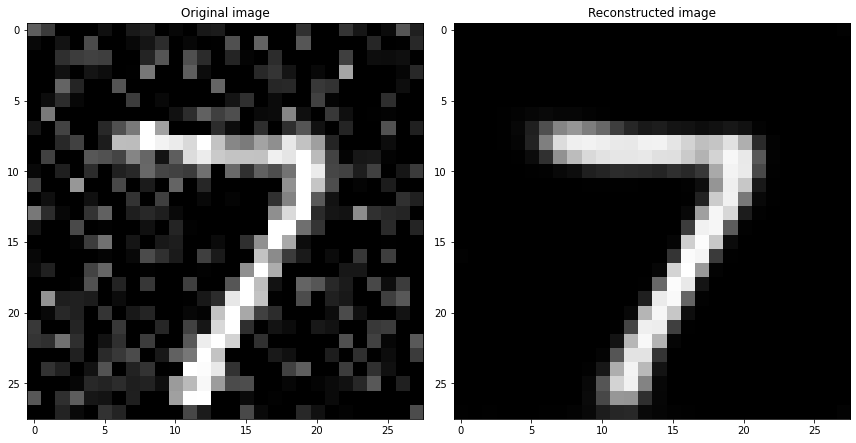

TRAIN - EPOCH 24/40 - loss: 0.012639
VALIDATION - EPOCH 24/40 - loss: 0.012984


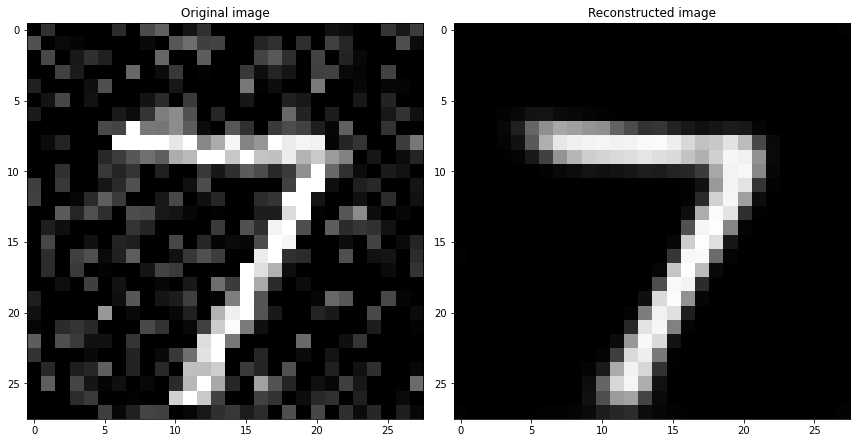

TRAIN - EPOCH 25/40 - loss: 0.013841
VALIDATION - EPOCH 25/40 - loss: 0.012892


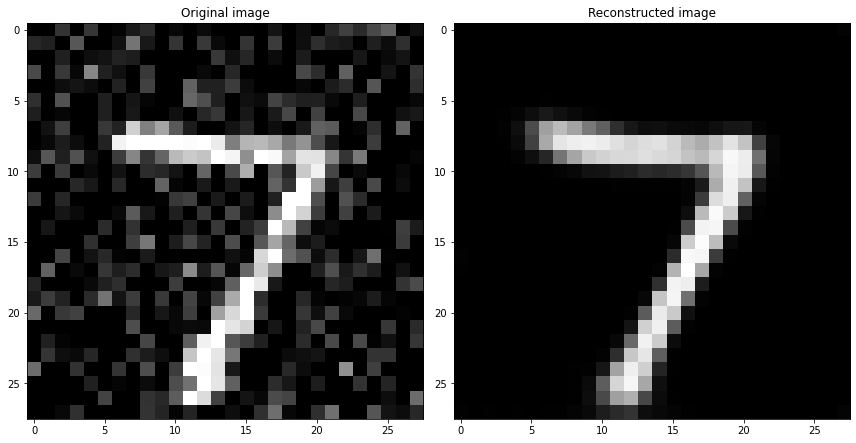

TRAIN - EPOCH 26/40 - loss: 0.013588
VALIDATION - EPOCH 26/40 - loss: 0.012764


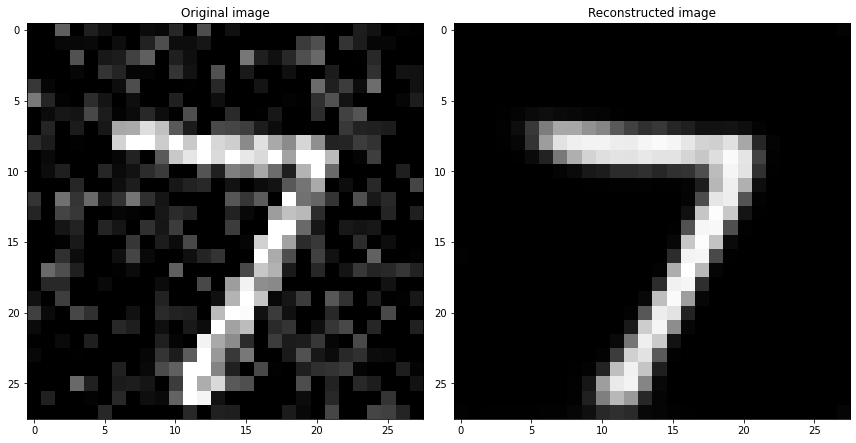

TRAIN - EPOCH 27/40 - loss: 0.013716
VALIDATION - EPOCH 27/40 - loss: 0.012685


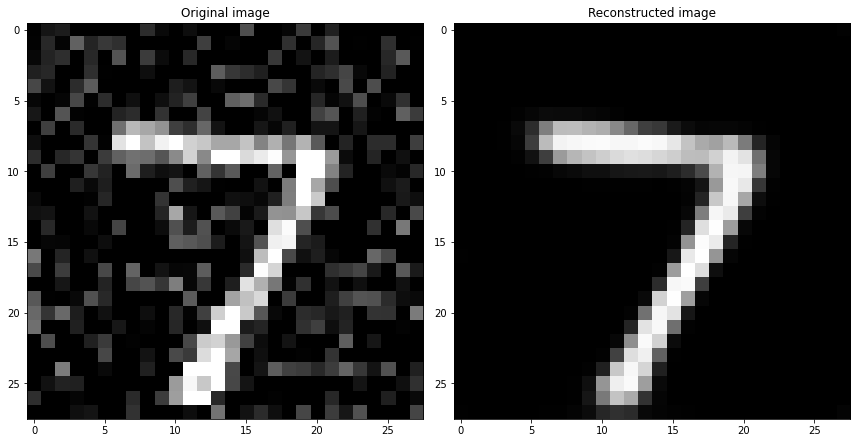

TRAIN - EPOCH 28/40 - loss: 0.012752
VALIDATION - EPOCH 28/40 - loss: 0.012673


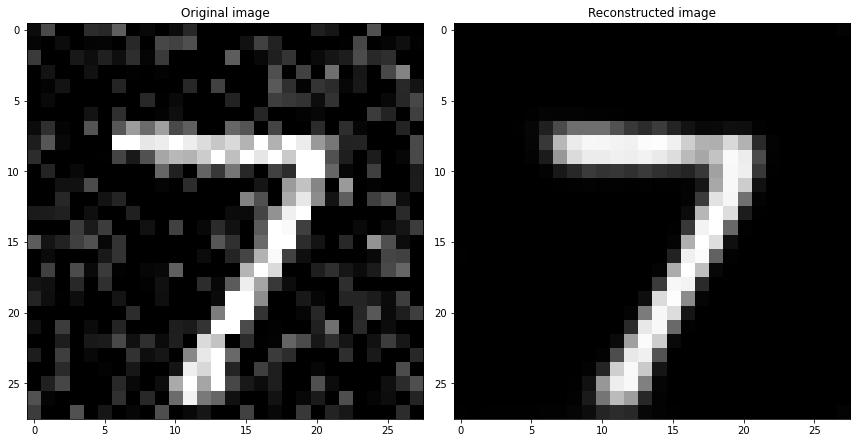

TRAIN - EPOCH 29/40 - loss: 0.013108
VALIDATION - EPOCH 29/40 - loss: 0.012519


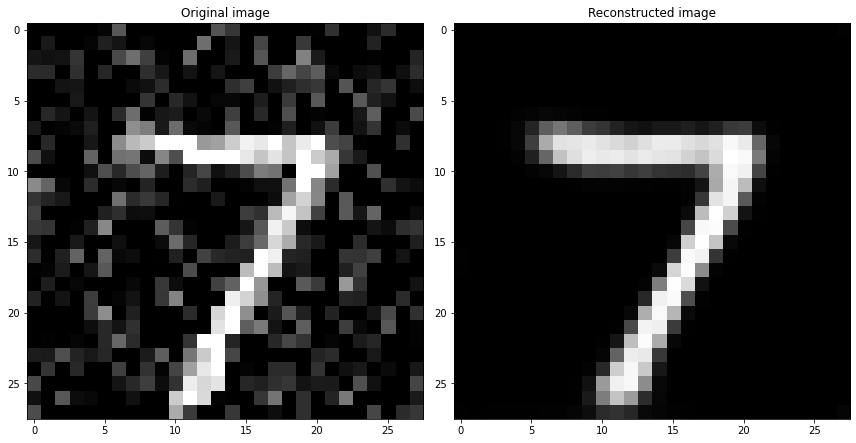

TRAIN - EPOCH 30/40 - loss: 0.013121
VALIDATION - EPOCH 30/40 - loss: 0.012511


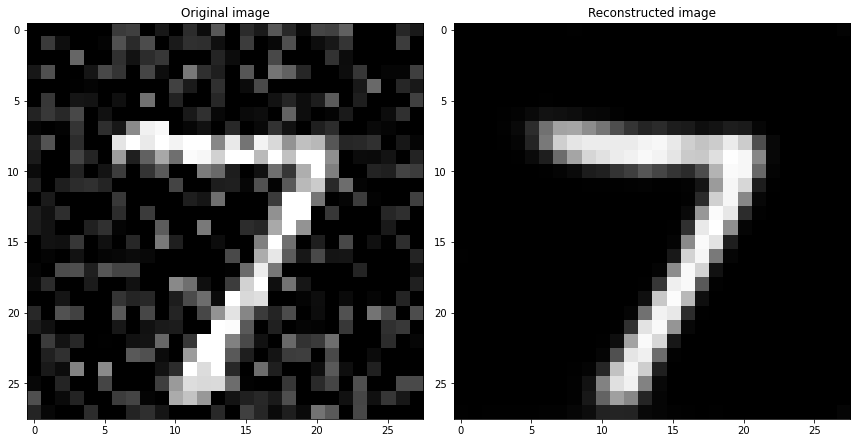

TRAIN - EPOCH 31/40 - loss: 0.013336
VALIDATION - EPOCH 31/40 - loss: 0.012562


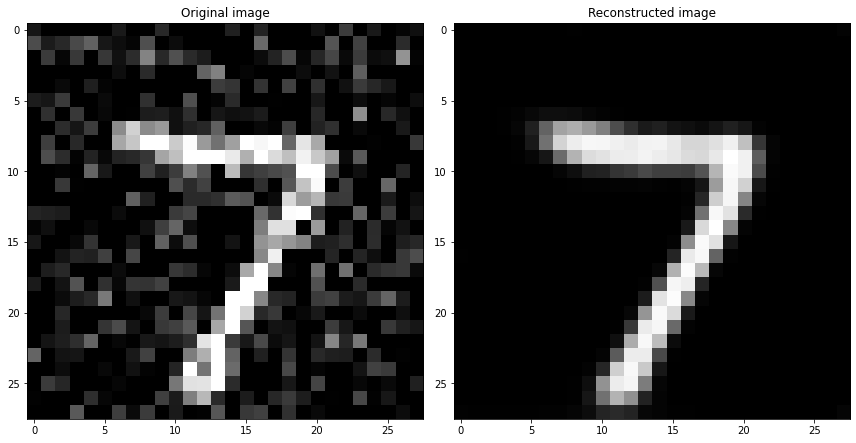

TRAIN - EPOCH 32/40 - loss: 0.012788
VALIDATION - EPOCH 32/40 - loss: 0.012430


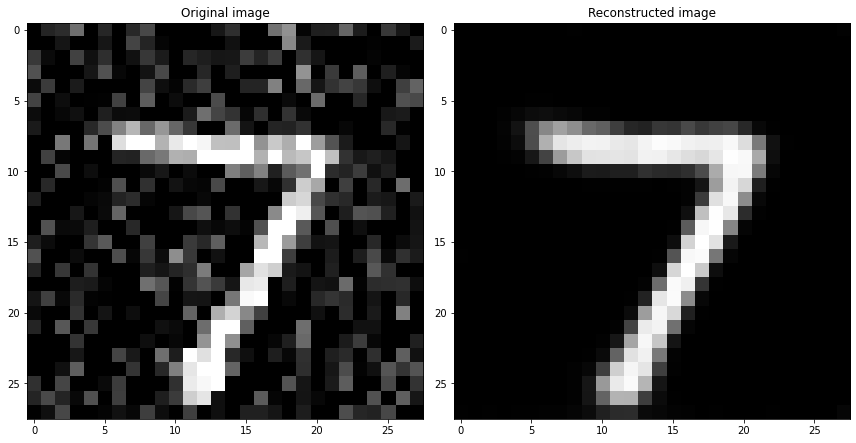

TRAIN - EPOCH 33/40 - loss: 0.011357
VALIDATION - EPOCH 33/40 - loss: 0.012498


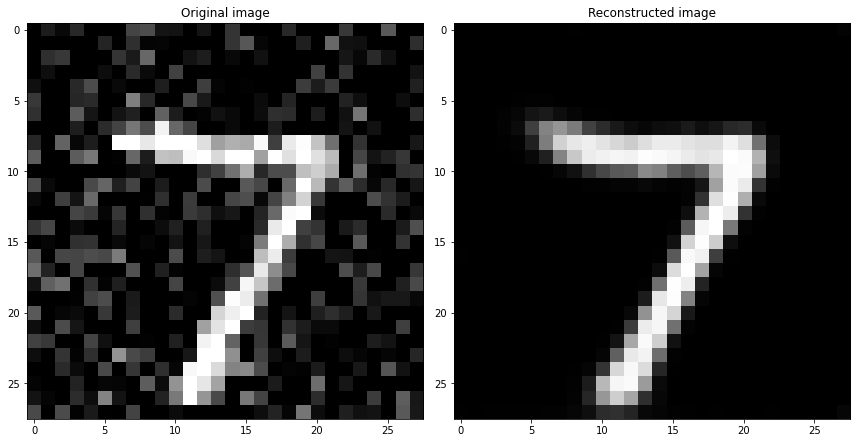

TRAIN - EPOCH 34/40 - loss: 0.011545
VALIDATION - EPOCH 34/40 - loss: 0.012277


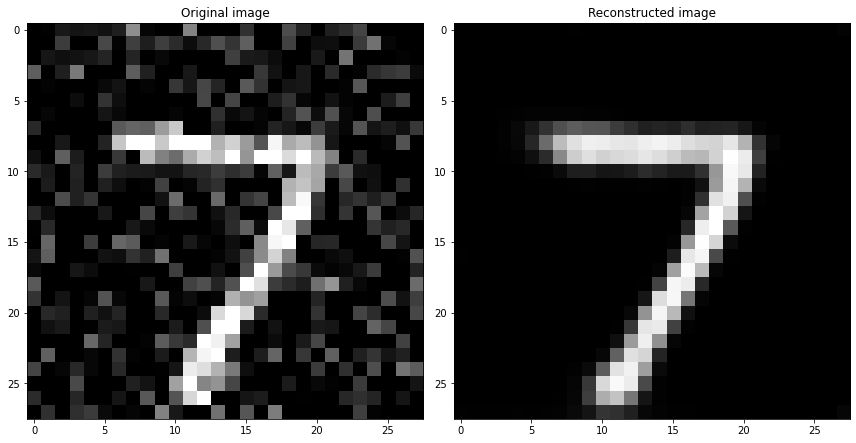

TRAIN - EPOCH 35/40 - loss: 0.011900
VALIDATION - EPOCH 35/40 - loss: 0.012345


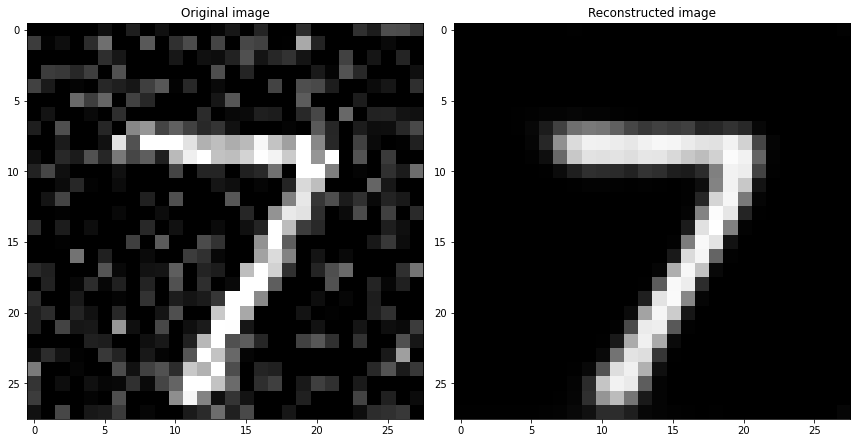

TRAIN - EPOCH 36/40 - loss: 0.012041
VALIDATION - EPOCH 36/40 - loss: 0.012209


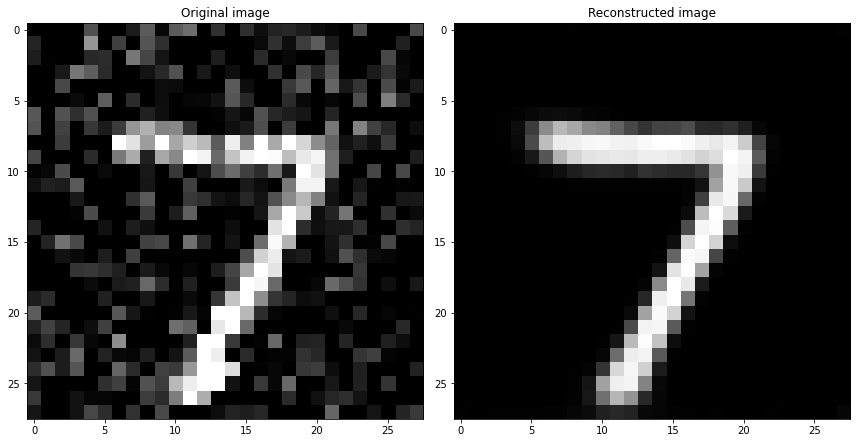

TRAIN - EPOCH 37/40 - loss: 0.011282
VALIDATION - EPOCH 37/40 - loss: 0.012094


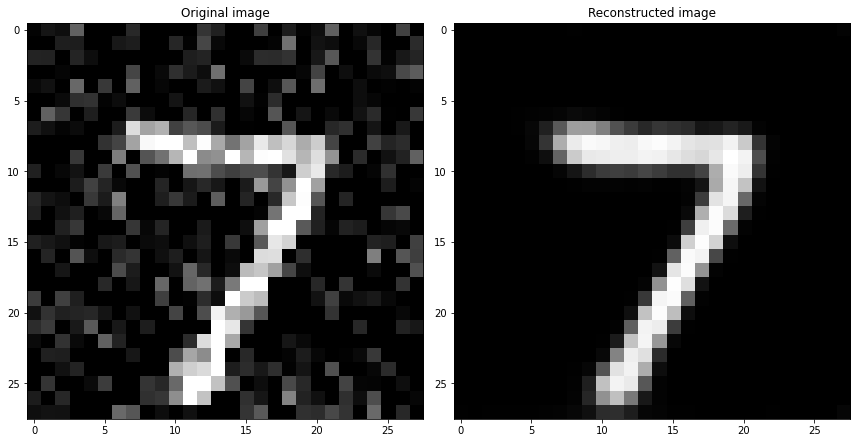

TRAIN - EPOCH 38/40 - loss: 0.012816
VALIDATION - EPOCH 38/40 - loss: 0.012157


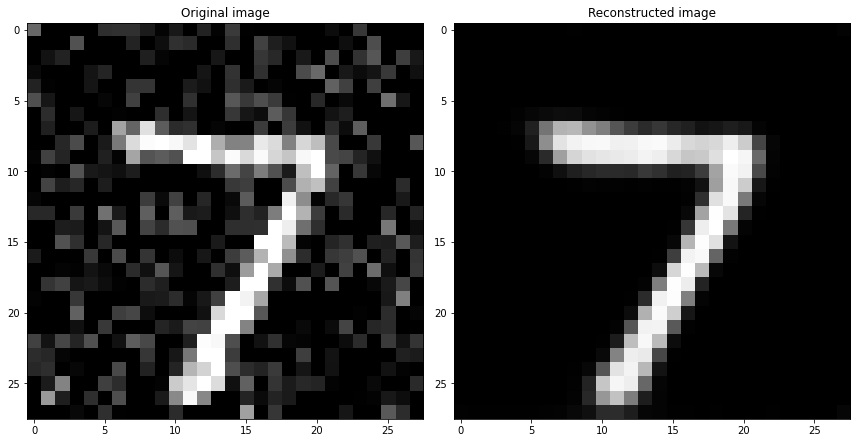

TRAIN - EPOCH 39/40 - loss: 0.012594
VALIDATION - EPOCH 39/40 - loss: 0.012182


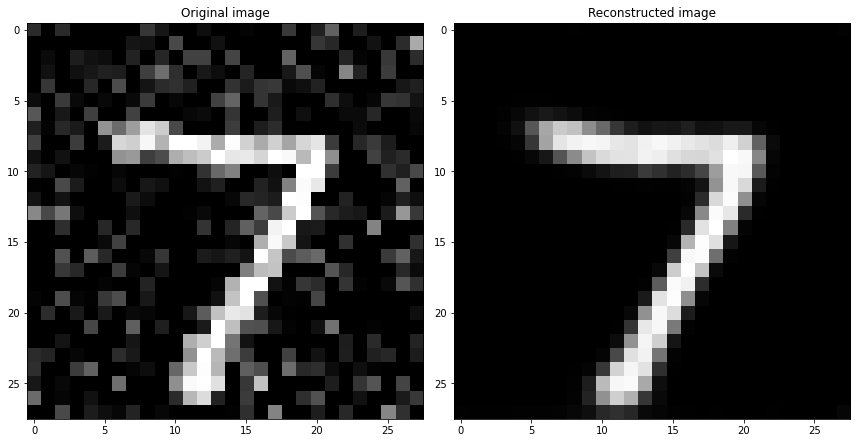

TRAIN - EPOCH 40/40 - loss: 0.012028
VALIDATION - EPOCH 40/40 - loss: 0.012005


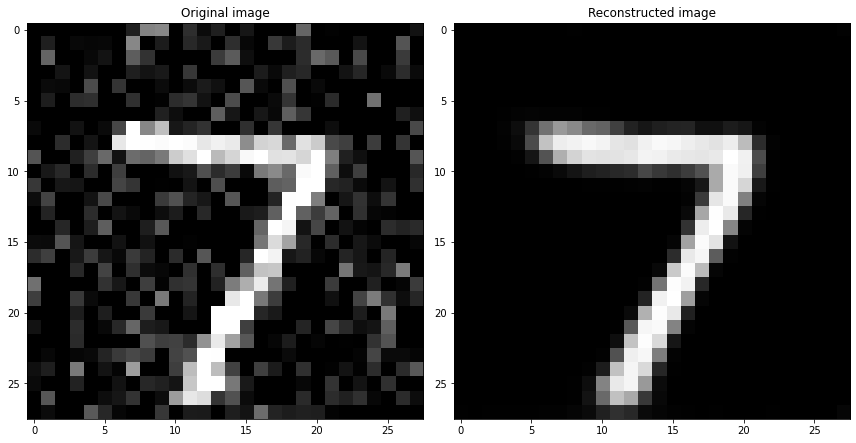

In [18]:
num_epochs=40
early_stopping=5
encoded_space_dim = 10
lin_layer=128
learning_rate=1e-3
l2=1e-5


# Initialize the networks
encoder = Encoder(encoded_space_dim=encoded_space_dim, lin_layer=lin_layer)
decoder = Decoder(encoded_space_dim=encoded_space_dim, lin_layer=lin_layer)

# Define the loss function
loss_fn = torch.nn.MSELoss()

# Define an optimizer
params_to_optimize = [{'params': encoder.parameters()}, {'params': decoder.parameters()}]
optim = torch.optim.Adam(params_to_optimize, lr=learning_rate, weight_decay=l2)

# Move to the device
encoder.to(device)
decoder.to(device)
    
    
# Training phase
train_loss_log,val_loss_log=training(num_epochs,
                                    early_stopping,
                                    encoder,
                                    decoder,
                                    loss_fn,
                                    optim,
                                    train_dataloader,
                                    test_dataset,
                                    device,
                                    noise=True)

In [ ]:
# Plot losses
plt.figure(figsize=(6,4))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(val_loss_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

In [ ]:
# Print losses
train_loss=train_loss_log[-1]
val_loss=val_loss_log[-1]

print("Train Loss:\t",round(float(train_loss), 4))
print("Val Loss:\t",round(float(val_loss), 4))

#  Convolutional Autoencoder using a Supervised Classification

In [ ]:
# Split the trainig dataset into train and validation 
train_data, val_data = torch.utils.data.random_split(train_dataset,
                                                     [len(train_dataset)-int(len(train_dataset) * 0.2),
                                                      int(len(train_dataset) * 0.2)])

print('Samples in training set:',len(train_data))
print('Samples in validation set:',len(val_data))

In [ ]:
# Apply transformation to train dataset and test dataset
train_data.transform = train_transform
val_data.transform = train_transform

# Define train dataloader enabling the shuffle of the data
train_data_load = DataLoader(train_data, batch_size=256, shuffle=True)
# Define test dataloader without shuffle the data
val_data_load = DataLoader(val_data, batch_size=len(val_data), shuffle=False)

In [ ]:
output_layer = nn.Linear(encoded_space_dim,10)
output_layer.to(device)
# Define the loss function
loss_func_supervised = nn.CrossEntropyLoss()

#optimize the parameters of both the encoder and the layer fot classification
params_to_optimize = [
        {'params': encoder.parameters()},
        {'params': output_layer.parameters()}
    ]

optimizer_sup = torch.optim.Adam(params_to_optimize, lr=1e-3)

In [ ]:
def training_supervised(encoder, output_layer, train_data_load):
  encoder.train()
  output_layer.train()
  for sample_batched in train_data_load:
      # Move data to device
      x_batch = sample_batched[0][0].to(device)
      label_batch = sample_batched[1].to(device)

      # Forward pass
      x = encoder(x_batch)
      out = output_layer(x)
      
      # Compute loss
      loss = loss_func_supervised(out, label_batch)

      # Backpropagation
      encoder.zero_grad()
      output_layer.zero_grad()
      loss.backward()

      # Update the weights
      optimizer_sup.step()

      # Save train loss for this batch
      loss_batch = loss.detach().cpu().numpy()
      train_loss.append(loss_batch)

      #get the accuracy for this batch
      pred = np.argmax(out.detach().cpu().numpy(), axis = 1)
      accuracy_train.append(np.sum(pred == np.array(label_batch.cpu())))

In [ ]:
def validation_supervised(encoder, output_layer, val_dataloader_sup):
  # Evaluate the encoder and decoder
  encoder.eval()
  output_layer.eval()
  with torch.no_grad(): # Disable gradient tracking
    for sample_batched in val_dataloader_sup:
      # Move data to device
      x_batch = sample_batched[0][0].to(device)
      label_batch = sample_batched[1].to(device)

      # Forward pass
      x = encoder(x_batch)
      out = output_layer(x)

      # Compute loss
      loss = loss_func_supervised(out, label_batch)

      # Save val loss for this batch
      loss_batch = loss.detach().cpu().numpy()
      val_loss.append(loss_batch)

      #get the accuracy for the val
      pred = np.argmax(out.detach().cpu().numpy(), axis = 1)
      accuracy_val.append(np.sum(pred == np.array(label_batch.cpu())))

**Training**

In [ ]:
num_epochs = 20
acc_train = 0
acc_val = 0
train_loss_log = []
val_loss_log = []
for epoch_num in range(num_epochs):
    # TRAIN
    accuracy_train = []
    accuracy_val = []
    train_loss= []
    # Training mode 
    training_supervised(encoder, output_layer, train_data_load)

    # Save the average train loss
    train_loss = np.mean(train_loss)
    train_loss_log.append(train_loss)

    # VALIDATION
    val_loss= []
    # Evaluation mode
    validation_supervised(encoder, output_layer, val_data_load)

    # Save average validation loss
    val_loss = np.mean(val_loss)
    val_loss_log.append(val_loss)

    acc_train = np.sum(accuracy_train)/len(train_data)
    acc_val = np.sum(accuracy_val)/len(val_data)
    print("Epoch", epoch_num + 1, "= Average train loss:[", train_loss, "] ","Accuracy train:[", np.round(acc_train,5),"] " ,"Average validation loss: [", val_loss, "]", "Accuracy validation:[",  np.round(acc_val,5),"]")
print("\n")

In [ ]:
# Plot losses
plt.figure(figsize=(6,4))
plt.plot(train_loss_log, label='Train loss')
plt.plot(val_loss_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0,1])
plt.grid()
plt.legend()
plt.show()

In [ ]:
test_loss = []
acc = 0

y_test=[]
y_pred=[]

# Evaluate the encoder and decoder
encoder.eval()
output_layer.eval()
with torch.no_grad(): 
    # Define the lists to store the outputs for each batch
    output = []
    label = []
    for sample_batched in test_dataloader:
        # Move to device
        x_batch = sample_batched[0][0].to(device)
        y = sample_batched[1].to(device)
        # Encode data
        x = encoder(x_batch)
        out = output_layer(x)

        y_test.append(y)
        y_pred.append(out)

        # Append the network output
        loss = loss_func_supervised(out, y)
        test_loss.append(loss.detach().cpu().numpy())

        pred = np.argmax(out.detach().cpu().numpy(), axis = 1)
        right = np.sum(pred == np.array(y.cpu()))
        acc = acc + right

    # Evaluate loss
    test_loss = np.mean(test_loss)

print("Test loss MODEL:[", float(test_loss),"]", " Accuracy of MODEL:[", np.round(acc/len(test_dataset),5),"]")

In [ ]:
train_loss=train_loss_log[-1]
val_loss=val_loss_log[-1]

print("Train Loss:\t",round(float(train_loss),3))
print("Val Loss:\t",round(float(val_loss),3))
print("Test Loss:\t",round(float(test_loss),3))

print("Train Accuracy:\t",round(float(acc_train),3))
print("Val Accuracy:\t",round(float(acc_val),3))
print("Test Accuracy:\t",round(float(acc/len(test_dataset)),3))

#  Generative Adversarial Network

In [ ]:
class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()
        
        # Define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        
        # Fully-connected layer
        self.fc4 = nn.Linear(hidden_dim*4, output_size)
        
        # Dropout layer 
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # All hidden layers
        x = nn.functional.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = nn.functional.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = nn.functional.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # Final layer
        out = nn.functional.tanh(self.fc4(x))

        return out

In [ ]:
class Discriminator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator, self).__init__()
        
        # Define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
        
        # Fully-connected layer
        self.fc4 = nn.Linear(hidden_dim, output_size)
        
        # Fropout layer 
        self.dropout = nn.Dropout(0.3)
        
        
    def forward(self, x):
        # flatten image
        x = x.view(-1, 28*28)
        # all hidden layers
        x = nn.functional.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = nn.functional.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = nn.functional.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # Final layer
        out = self.fc4(x)

        return out

In [ ]:
# Discriminator hyperparams

# Size of input image to discriminator (28*28)
input_size = 784
# Size of discriminator output (real or fake)
d_output_size = 1
# Size of last hidden layer in the discriminator
d_hidden_size = 32

# Generator hyperparams

# Size of latent vector to give to generator
z_size = 100
# Size of discriminator output (generated image)
g_output_size = 784
# Size of first hidden layer in the generator
g_hidden_size = 32

In [ ]:
# Initialize discriminator and generator
D = Discriminator(input_size, d_hidden_size, d_output_size)
G = Generator(z_size, g_hidden_size, g_output_size)

# Summarize models
print(D)
print(G)

In [ ]:
# Calculate losses
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
        
    # numerically stable loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [ ]:
# Create optimizers for the discriminator and generator
d_optimizer = torch.optim.Adam(D.parameters(), learning_rate)
g_optimizer = torch.optim.Adam(G.parameters(), learning_rate)

In [ ]:
# training hyperparams
num_epochs = 75

# keep track of loss and generated, "fake" samples
samples = []
losses = []

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
D.train()
G.train()
for epoch in range(num_epochs):

    
    for image_batch, _ in train_dataloader:

        image= image_batch[0].to(device)

        batch_size = image.size(0)
        
        # Rescaling step 
        image = image*2 - 1  # rescale input images from [0,1) to [-1, 1)
        

        # Train the Discriminator    
        d_optimizer.zero_grad()
        
        # 1. Train with real images

        # Compute the discriminator losses on real images 
        D_real = D(image)
        d_real_loss = real_loss(D_real, smooth=True)
        
        # 2. Train with fake images
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images        
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # Add up loss
        d_loss = d_real_loss + d_fake_loss

        d_loss.backward()
        d_optimizer.step()
        
        

        # Train the Generator
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images 
        D_fake = D(fake_images)
        # Use real loss to flip labels
        g_loss = real_loss(D_fake) 
        
        g_loss.backward()
        g_optimizer.step()


        print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    # Append discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))
    
    # generate and save sample, fake images
    G.eval() 
    samples_z = G(fixed_z)
    samples.append(samples_z)
    # Back to train mode
    G.train() 


In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()